Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data and all the important libraries

In [14]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Suppress tensorflow warnings. Only log the errors
import logging
tf.get_logger().setLevel(logging.ERROR)

In [15]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('./Train')
data_dir_test = pathlib.Path('./Test')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [16]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118



Images available in train dataset: 2239

Images available in test dataset: 118

This assignment uses a dataset of about 2239 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [17]:
batch_size = 32
img_height = 180
img_width = 180
seed = 123

Use 80% of the images for training, and 20% for validation.

In [18]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=seed,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [19]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=seed,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [20]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

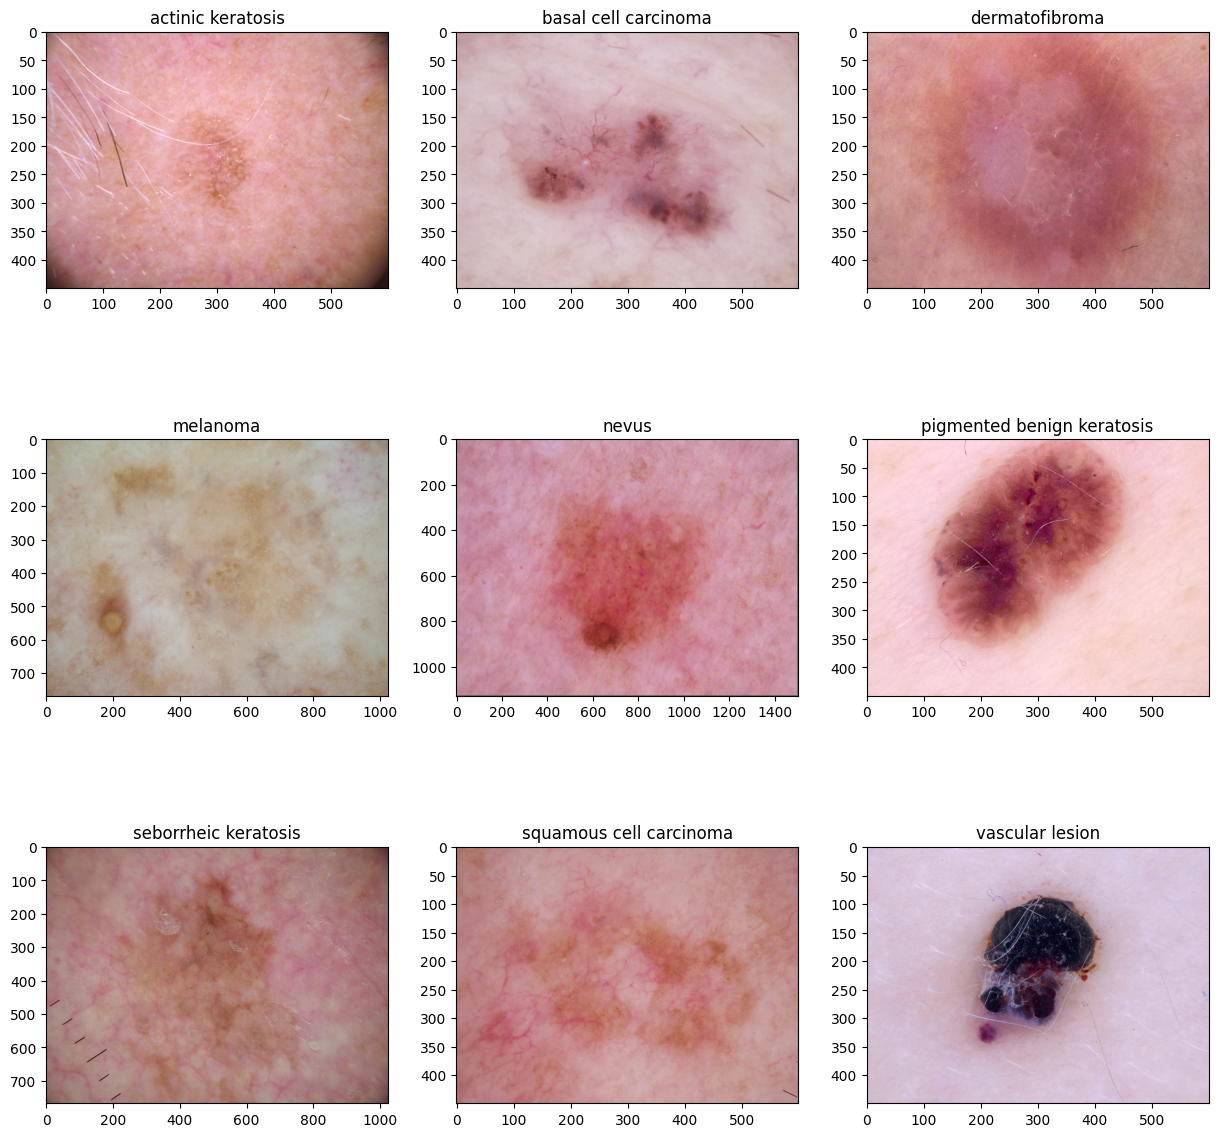

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
for i in range(len(class_names)):
  plt.subplot(3,3,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[0]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [23]:
# CNN Model - Initial
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPooling2D())

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 128)      

In [25]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 128)      

### Train the model

In [26]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 13s 127ms/step - loss: 2.6338 - accuracy: 0.1964 - val_loss: 1.9082 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 4s 70ms/step - loss: 1.8012 - accuracy: 0.3443 - val_loss: 1.6719 - val_accuracy: 0.3982
Epoch 3/20
56/56 [==============================] - 3s 60ms/step - loss: 1.5613 - accuracy: 0.4498 - val_loss: 1.5157 - val_accuracy: 0.4966
Epoch 4/20
56/56 [==============================] - 3s 57ms/step - loss: 1.4485 - accuracy: 0.4710 - val_loss: 1.5257 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 3s 58ms/step - loss: 1.2812 - accuracy: 0.5536 - val_loss: 1.5630 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 3s 60ms/step - loss: 1.1295 - accuracy: 0.6150 - val_loss: 1.9290 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 3s 58ms/step - loss: 0.9732 - accuracy: 0.6758 - val_loss: 2.3952 - val_accuracy: 0.4877
Epoch 8/20


### Visualizing training results

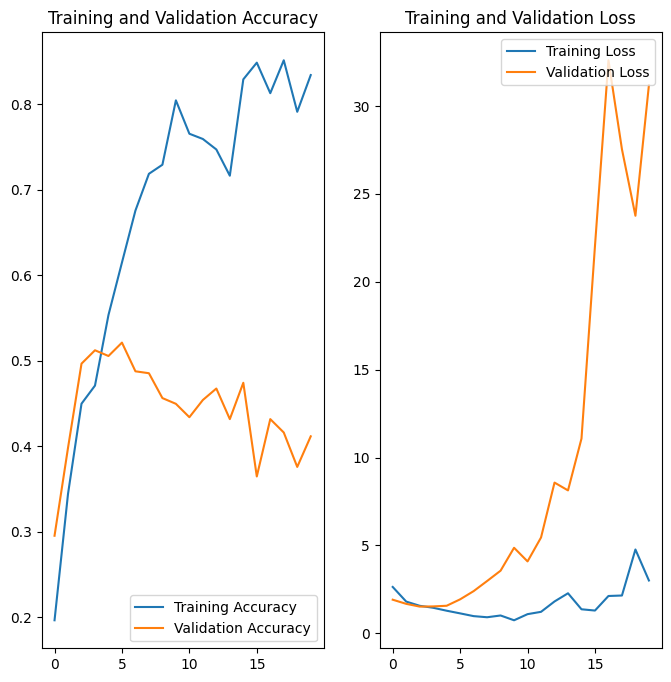

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observations:
With an increasing number of epochs, the training accuracy rises, while the validation accuracy plateaus at 50-55%. Simultaneously, the training loss diminishes, but the validation loss initially decreases and later escalates. Overall, the model achieves a validation accuracy of around 50-55%. The considerable gap between high training accuracy and low validation accuracy indicates overfitting, signaling the need for tuning.

Conclusion:
Overfitting can arise from various factors, including a small training dataset lacking diverse samples, the presence of noisy or irrelevant data, prolonged training on a single dataset, or a model's excessive complexity, leading to the incorporation of noise. In our case, it seems the training data is insufficient. Therefore, we plan to implement a data augmentation strategy to generate a more extensive dataset.

Image data augmentation, a technique for creating modified versions of images, will be employed to artificially expand the training dataset. This approach aims to address the limitations posed by the current dataset size and enhance the model's generalization capabilities.

In [28]:
 
#Performing data augmentation on the training dataset
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

2024-01-17 22:50:13.143564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:14.233928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:14.324425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:14.405582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:14.507147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:14.583280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

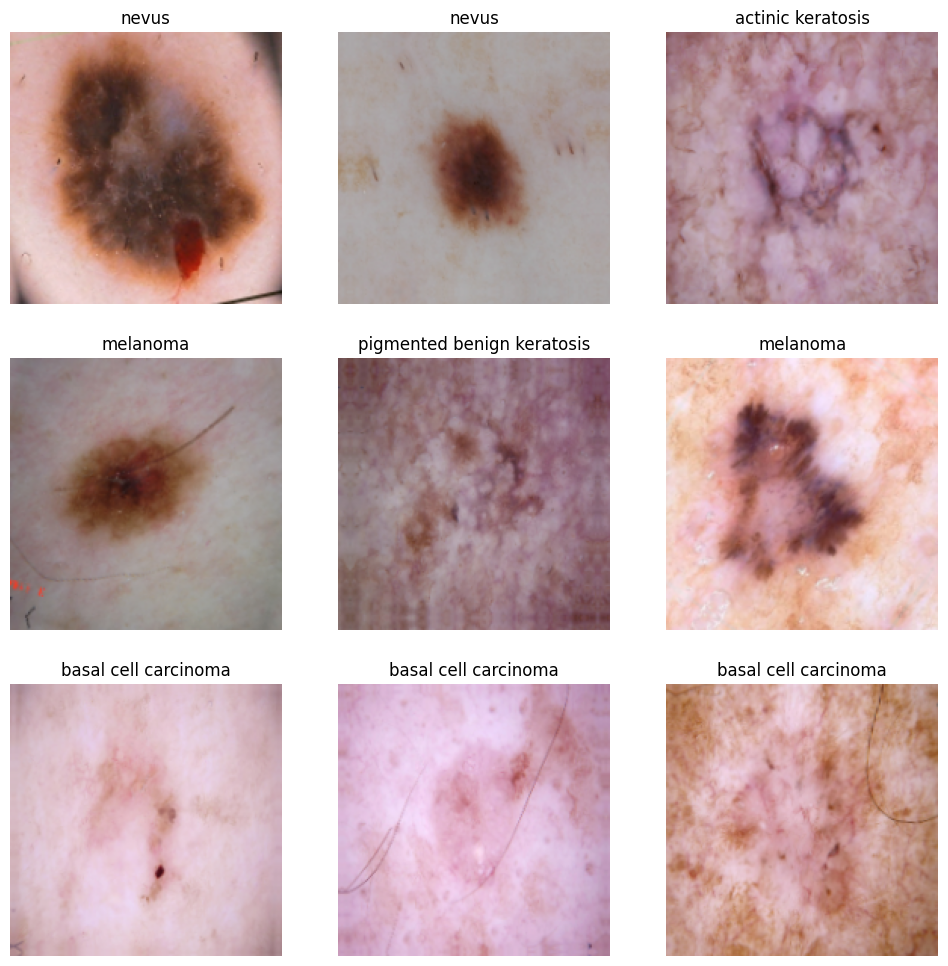

In [29]:

# visualizing the augmentation strategy for one instance of a training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augmentation(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [30]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augmentation,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))



### Compiling the model

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [32]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


2024-01-17 22:50:16.688622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/56 [>.............................] - ETA: 9s - loss: 2.4820 - accuracy: 0.2188  

2024-01-17 22:50:20.565511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:20.748181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/56 [=>............................] - ETA: 8s - loss: 2.2919 - accuracy: 0.2031

2024-01-17 22:50:20.890710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:21.039444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/56 [==>...........................] - ETA: 7s - loss: 2.2349 - accuracy: 0.1875

2024-01-17 22:50:21.168284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:21.301674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/56 [===>..........................] - ETA: 6s - loss: 2.1937 - accuracy: 0.1836

2024-01-17 22:50:21.433596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:21.563145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/56 [====>.........................] - ETA: 6s - loss: 2.1451 - accuracy: 0.2062

2024-01-17 22:50:21.692735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:21.826576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/56 [=====>........................] - ETA: 6s - loss: 2.1447 - accuracy: 0.2083

2024-01-17 22:50:21.956428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:22.085218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/56 [======>.......................] - ETA: 5s - loss: 2.1371 - accuracy: 0.2076

2024-01-17 22:50:22.212761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:22.359434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/56 [=======>......................] - ETA: 5s - loss: 2.1307 - accuracy: 0.1992

2024-01-17 22:50:22.486231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:22.629354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/56 [========>.....................] - ETA: 5s - loss: 2.1233 - accuracy: 0.2014

2024-01-17 22:50:22.758302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:22.886150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/56 [=========>....................] - ETA: 4s - loss: 2.1110 - accuracy: 0.2016

2024-01-17 22:50:23.014419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:23.142524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/56 [==========>...................] - ETA: 4s - loss: 2.1110 - accuracy: 0.1989

2024-01-17 22:50:23.272134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:23.402783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/56 [===========>..................] - ETA: 4s - loss: 2.1003 - accuracy: 0.2005

2024-01-17 22:50:23.544831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:23.673690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/56 [============>.................] - ETA: 4s - loss: 2.0969 - accuracy: 0.1959

2024-01-17 22:50:23.800558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:23.933376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/56 [==============>...............] - ETA: 3s - loss: 2.0924 - accuracy: 0.1920

2024-01-17 22:50:24.076835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:24.213921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/56 [===============>..............] - ETA: 3s - loss: 2.0950 - accuracy: 0.1896

2024-01-17 22:50:24.346760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:24.475650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/56 [================>.............] - ETA: 3s - loss: 2.0906 - accuracy: 0.1807

2024-01-17 22:50:24.611728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:24.740018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/56 [=================>............] - ETA: 2s - loss: 2.0786 - accuracy: 0.1875

2024-01-17 22:50:24.876841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:25.010098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/56 [==================>...........] - ETA: 2s - loss: 2.0786 - accuracy: 0.1875

2024-01-17 22:50:25.144435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:25.275303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/56 [===================>..........] - ETA: 2s - loss: 2.0769 - accuracy: 0.1867

2024-01-17 22:50:25.419891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:25.546571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/56 [====================>.........] - ETA: 2s - loss: 2.0722 - accuracy: 0.1930

2024-01-17 22:50:25.676247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:25.804182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/56 [=====================>........] - ETA: 1s - loss: 2.0709 - accuracy: 0.1949

2024-01-17 22:50:25.932306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:26.061632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/56 [======================>.......] - ETA: 1s - loss: 2.0716 - accuracy: 0.1946

2024-01-17 22:50:26.187564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:26.315316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/56 [=======================>......] - ETA: 1s - loss: 2.0708 - accuracy: 0.1963

2024-01-17 22:50:26.446702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:26.575144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/56 [========================>.....] - ETA: 1s - loss: 2.0728 - accuracy: 0.1973

2024-01-17 22:50:26.706661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:26.838018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/56 [=========================>....] - ETA: 0s - loss: 2.0767 - accuracy: 0.1937

2024-01-17 22:50:26.968008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:27.101769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/56 [==========================>...] - ETA: 0s - loss: 2.0737 - accuracy: 0.1959

2024-01-17 22:50:27.229603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:27.360572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/56 [===========================>..] - ETA: 0s - loss: 2.0714 - accuracy: 0.1985

2024-01-17 22:50:27.491660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:27.619549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - ETA: 0s - loss: 2.0703 - accuracy: 0.2009

2024-01-17 22:50:27.752919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 14s 171ms/step - loss: 2.0703 - accuracy: 0.2009 - val_loss: 2.0353 - val_accuracy: 0.2058
Epoch 2/30


2024-01-17 22:50:29.964564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/56 [>.............................] - ETA: 7s - loss: 2.0668 - accuracy: 0.1719 

2024-01-17 22:50:30.230407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:30.377309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/56 [=>............................] - ETA: 7s - loss: 2.0323 - accuracy: 0.1953

2024-01-17 22:50:30.508021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:30.641557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/56 [==>...........................] - ETA: 6s - loss: 2.0256 - accuracy: 0.1771

2024-01-17 22:50:30.783086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:30.923335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/56 [===>..........................] - ETA: 6s - loss: 2.0087 - accuracy: 0.1836

2024-01-17 22:50:31.050488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:31.189527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/56 [====>.........................] - ETA: 6s - loss: 1.9815 - accuracy: 0.2094

2024-01-17 22:50:31.334280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:31.461407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/56 [=====>........................] - ETA: 5s - loss: 1.9666 - accuracy: 0.2214

2024-01-17 22:50:31.604091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:31.732546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/56 [======>.......................] - ETA: 5s - loss: 1.9786 - accuracy: 0.2277

2024-01-17 22:50:31.869319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:31.993790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/56 [=======>......................] - ETA: 5s - loss: 1.9926 - accuracy: 0.2246

2024-01-17 22:50:32.120438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:32.252957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/56 [========>.....................] - ETA: 5s - loss: 1.9955 - accuracy: 0.2326

2024-01-17 22:50:32.390767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:32.518136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/56 [=========>....................] - ETA: 4s - loss: 1.9980 - accuracy: 0.2313

2024-01-17 22:50:32.643981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:32.769614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/56 [==========>...................] - ETA: 4s - loss: 1.9959 - accuracy: 0.2344

2024-01-17 22:50:32.898200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:33.025833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/56 [===========>..................] - ETA: 4s - loss: 1.9997 - accuracy: 0.2305

2024-01-17 22:50:33.156804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:33.284041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/56 [============>.................] - ETA: 3s - loss: 2.0028 - accuracy: 0.2344

2024-01-17 22:50:33.422163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:33.554801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/56 [==============>...............] - ETA: 3s - loss: 1.9938 - accuracy: 0.2333

2024-01-17 22:50:33.693205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:33.828308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/56 [===============>..............] - ETA: 3s - loss: 1.9935 - accuracy: 0.2292

2024-01-17 22:50:33.965267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:34.112160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/56 [================>.............] - ETA: 3s - loss: 1.9953 - accuracy: 0.2285

2024-01-17 22:50:34.249568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:34.377125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/56 [=================>............] - ETA: 2s - loss: 1.9954 - accuracy: 0.2279

2024-01-17 22:50:34.527751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:34.659850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/56 [==================>...........] - ETA: 2s - loss: 1.9968 - accuracy: 0.2240

2024-01-17 22:50:34.790881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:34.930861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/56 [===================>..........] - ETA: 2s - loss: 1.9991 - accuracy: 0.2204

2024-01-17 22:50:35.060857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:35.197059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/56 [====================>.........] - ETA: 2s - loss: 1.9996 - accuracy: 0.2172

2024-01-17 22:50:35.339693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:35.467079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/56 [=====================>........] - ETA: 1s - loss: 1.9987 - accuracy: 0.2158

2024-01-17 22:50:35.595403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:35.721615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/56 [======================>.......] - ETA: 1s - loss: 2.0028 - accuracy: 0.2159

2024-01-17 22:50:35.851013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:35.978510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/56 [=======================>......] - ETA: 1s - loss: 2.0030 - accuracy: 0.2147

2024-01-17 22:50:36.102164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:36.228750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/56 [========================>.....] - ETA: 1s - loss: 2.0007 - accuracy: 0.2129

2024-01-17 22:50:36.366377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:36.493594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/56 [=========================>....] - ETA: 0s - loss: 2.0018 - accuracy: 0.2138

2024-01-17 22:50:36.620626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:36.746602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/56 [==========================>...] - ETA: 0s - loss: 2.0017 - accuracy: 0.2133

2024-01-17 22:50:36.875266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:37.004595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/56 [===========================>..] - ETA: 0s - loss: 2.0027 - accuracy: 0.2147

2024-01-17 22:50:37.160425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:37.314123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - ETA: 0s - loss: 2.0014 - accuracy: 0.2176

2024-01-17 22:50:37.441416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 144ms/step - loss: 2.0014 - accuracy: 0.2176 - val_loss: 1.9908 - val_accuracy: 0.2304
Epoch 3/30
 1/56 [..............................] - ETA: 7s - loss: 2.0450 - accuracy: 0.1875

2024-01-17 22:50:38.160022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:38.288485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 7s - loss: 2.0093 - accuracy: 0.2292

2024-01-17 22:50:38.439373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:38.564756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 6s - loss: 2.0016 - accuracy: 0.2438

2024-01-17 22:50:38.701705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:38.829750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 1.9844 - accuracy: 0.2589

2024-01-17 22:50:38.960322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:39.091455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 1.9560 - accuracy: 0.2674

2024-01-17 22:50:39.217704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:39.343131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 5s - loss: 1.9584 - accuracy: 0.2670

2024-01-17 22:50:39.474375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:39.602455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 6s - loss: 1.9778 - accuracy: 0.2596

2024-01-17 22:50:39.803525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:39.978479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 1.9459 - accuracy: 0.2750

2024-01-17 22:50:40.111551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:40.305244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 1.9472 - accuracy: 0.2831

2024-01-17 22:50:40.439996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:40.568307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 5s - loss: 1.9495 - accuracy: 0.2714

2024-01-17 22:50:40.709294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:40.859294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 1.9455 - accuracy: 0.2753

2024-01-17 22:50:40.990696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:41.123084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 1.9369 - accuracy: 0.2717

2024-01-17 22:50:41.255601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:41.395037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 1.9354 - accuracy: 0.2738

2024-01-17 22:50:41.523840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:41.651623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 4s - loss: 1.9376 - accuracy: 0.2755

2024-01-17 22:50:41.783805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:41.916631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 1.9362 - accuracy: 0.2791

2024-01-17 22:50:42.060903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:42.189026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 1.9307 - accuracy: 0.2853

2024-01-17 22:50:42.317053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:42.444598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 3s - loss: 1.9222 - accuracy: 0.2898

2024-01-17 22:50:42.582273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:42.735069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 1.9218 - accuracy: 0.2929

2024-01-17 22:50:42.892356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:43.045571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 1.9179 - accuracy: 0.2905

2024-01-17 22:50:43.197661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:43.328866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 1.9181 - accuracy: 0.2917

2024-01-17 22:50:43.476228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:43.604108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 2s - loss: 1.9198 - accuracy: 0.2934

2024-01-17 22:50:43.728817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:43.857684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 1.9163 - accuracy: 0.2914

2024-01-17 22:50:43.984514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:44.110100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 1.9122 - accuracy: 0.2944

2024-01-17 22:50:44.248476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:44.388189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 1.9068 - accuracy: 0.3005

2024-01-17 22:50:44.518413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:44.654612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 1.9112 - accuracy: 0.3004

2024-01-17 22:50:44.796190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:44.932280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 1.9092 - accuracy: 0.3015

2024-01-17 22:50:45.062114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:45.253844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 1.9203 - accuracy: 0.2942

2024-01-17 22:50:45.414007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:45.550751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 1.9242 - accuracy: 0.2903

2024-01-17 22:50:45.680971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:45.809985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 150ms/step - loss: 1.9222 - accuracy: 0.2924 - val_loss: 1.9245 - val_accuracy: 0.2282
Epoch 4/30
 1/56 [..............................] - ETA: 7s - loss: 1.8553 - accuracy: 0.3750

2024-01-17 22:50:46.519213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:46.657435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 6s - loss: 2.0089 - accuracy: 0.2396

2024-01-17 22:50:46.789513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:46.916132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 6s - loss: 1.9551 - accuracy: 0.2688

2024-01-17 22:50:47.048254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:47.174434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 1.9396 - accuracy: 0.2812

2024-01-17 22:50:47.306204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:47.432127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 1.9331 - accuracy: 0.2882

2024-01-17 22:50:47.557150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:47.683254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 5s - loss: 1.9393 - accuracy: 0.2812

2024-01-17 22:50:47.818183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:47.943624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 1.9406 - accuracy: 0.2788

2024-01-17 22:50:48.070798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:48.228529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 1.9205 - accuracy: 0.2771

2024-01-17 22:50:48.359088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:48.489780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 1.9001 - accuracy: 0.2868

2024-01-17 22:50:48.634569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:48.761794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 4s - loss: 1.9082 - accuracy: 0.2862

2024-01-17 22:50:48.889508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:49.029185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 1.9073 - accuracy: 0.2857

2024-01-17 22:50:49.155768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:49.282648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 1.8996 - accuracy: 0.2948

2024-01-17 22:50:49.406022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:49.536789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 1.8791 - accuracy: 0.3063

2024-01-17 22:50:49.663673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:49.796407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 1.8810 - accuracy: 0.3079

2024-01-17 22:50:49.942661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:50.069427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 1.8780 - accuracy: 0.3082

2024-01-17 22:50:50.197036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:50.323309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 1.8803 - accuracy: 0.3044

2024-01-17 22:50:50.447632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:50.575408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 2s - loss: 1.8798 - accuracy: 0.3021

2024-01-17 22:50:50.700586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:50.829326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 1.8770 - accuracy: 0.3018

2024-01-17 22:50:50.955946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:51.081580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 1.8792 - accuracy: 0.3015

2024-01-17 22:50:51.209093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:51.335714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 1.8704 - accuracy: 0.3069

2024-01-17 22:50:51.460160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:51.584353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 1s - loss: 1.8714 - accuracy: 0.3049

2024-01-17 22:50:51.716284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:51.847717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 1.8761 - accuracy: 0.3067

2024-01-17 22:50:52.013419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:52.151129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 1.8706 - accuracy: 0.3097

2024-01-17 22:50:52.283537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:52.410915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 1.8825 - accuracy: 0.3092

2024-01-17 22:50:52.551297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:52.682369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 1.8815 - accuracy: 0.3080

2024-01-17 22:50:52.834509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:52.965655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 1.8829 - accuracy: 0.3064

2024-01-17 22:50:53.100285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:53.232805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 1.8856 - accuracy: 0.3031

2024-01-17 22:50:53.365672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:53.495857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 1.8871 - accuracy: 0.3051

2024-01-17 22:50:53.630996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:53.761336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 143ms/step - loss: 1.8879 - accuracy: 0.3064 - val_loss: 1.8601 - val_accuracy: 0.3624
Epoch 5/30
 1/56 [..............................] - ETA: 7s - loss: 1.6983 - accuracy: 0.3750

2024-01-17 22:50:54.529509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:54.668058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 9s - loss: 1.8748 - accuracy: 0.3438

2024-01-17 22:50:54.837122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:55.023645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 8s - loss: 1.7876 - accuracy: 0.3938

2024-01-17 22:50:55.198779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:55.332902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 7s - loss: 1.7987 - accuracy: 0.3661

2024-01-17 22:50:55.461876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:55.592632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 7s - loss: 1.7724 - accuracy: 0.3785

2024-01-17 22:50:55.719786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:55.864527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 6s - loss: 1.7746 - accuracy: 0.3665

2024-01-17 22:50:55.989042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:56.116305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 6s - loss: 1.7658 - accuracy: 0.3678

2024-01-17 22:50:56.243607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:56.370156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 1.7529 - accuracy: 0.3771

2024-01-17 22:50:56.497379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:56.622871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 1.7624 - accuracy: 0.3768

2024-01-17 22:50:56.756266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:56.884152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 5s - loss: 1.7637 - accuracy: 0.3766

2024-01-17 22:50:57.013225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:57.139202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 1.7500 - accuracy: 0.3765

2024-01-17 22:50:57.264396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:57.389977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 1.7370 - accuracy: 0.3845

2024-01-17 22:50:57.514582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:57.642532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 1.7241 - accuracy: 0.3887

2024-01-17 22:50:57.792884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:57.917891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 1.7200 - accuracy: 0.3877

2024-01-17 22:50:58.044412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:58.176015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 1.7219 - accuracy: 0.3869

2024-01-17 22:50:58.332027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:58.458528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 1.7198 - accuracy: 0.3861

2024-01-17 22:50:58.583822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:58.712745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 3s - loss: 1.7113 - accuracy: 0.3892

2024-01-17 22:50:58.845992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:58.971877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 1.7067 - accuracy: 0.3884

2024-01-17 22:50:59.097404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:59.222950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 1.6972 - accuracy: 0.3910

2024-01-17 22:50:59.350017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:59.474562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 1.7014 - accuracy: 0.3894

2024-01-17 22:50:59.620937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:50:59.745837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 2s - loss: 1.6951 - accuracy: 0.3933

2024-01-17 22:50:59.887545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:00.014671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 1.6891 - accuracy: 0.3932

2024-01-17 22:51:00.148486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:00.287988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 1.6861 - accuracy: 0.3931

2024-01-17 22:51:00.412038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:00.539573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 1.6879 - accuracy: 0.3916

2024-01-17 22:51:00.665354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:00.791834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 1.6835 - accuracy: 0.3954

2024-01-17 22:51:00.916674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:01.041284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 1.6849 - accuracy: 0.3934

2024-01-17 22:51:01.165447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:01.287965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 1.6839 - accuracy: 0.3921

2024-01-17 22:51:01.418129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:01.554848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 1.6850 - accuracy: 0.3920

2024-01-17 22:51:01.683950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:01.810170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 142ms/step - loss: 1.6865 - accuracy: 0.3890 - val_loss: 1.7198 - val_accuracy: 0.3781
Epoch 6/30
 1/56 [..............................] - ETA: 7s - loss: 1.6054 - accuracy: 0.4062

2024-01-17 22:51:02.493428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:02.624696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 7s - loss: 1.6643 - accuracy: 0.3646

2024-01-17 22:51:02.762544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:02.916063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 6s - loss: 1.6848 - accuracy: 0.3500

2024-01-17 22:51:03.042289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:03.170204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 1.6772 - accuracy: 0.3795

2024-01-17 22:51:03.299052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:03.427562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 1.6548 - accuracy: 0.3785

2024-01-17 22:51:03.556713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:03.684105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 5s - loss: 1.6328 - accuracy: 0.3835

2024-01-17 22:51:03.809908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:03.940990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 1.6245 - accuracy: 0.3894

2024-01-17 22:51:04.077077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:04.201755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 1.6042 - accuracy: 0.4104

2024-01-17 22:51:04.331275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:04.458081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 1.6082 - accuracy: 0.4173

2024-01-17 22:51:04.587811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:04.714584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 4s - loss: 1.5802 - accuracy: 0.4243

2024-01-17 22:51:04.853121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:04.979441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 1.5699 - accuracy: 0.4360

2024-01-17 22:51:05.131732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:05.258769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 1.5990 - accuracy: 0.4280

2024-01-17 22:51:05.383827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:05.514097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 1.5922 - accuracy: 0.4325

2024-01-17 22:51:05.660800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:05.808771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/56 [============>.................] - ETA: 4s - loss: 1.6038 - accuracy: 0.4291

2024-01-17 22:51:06.260158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 4s - loss: 1.6039 - accuracy: 0.4294

2024-01-17 22:51:06.630966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 4s - loss: 1.6009 - accuracy: 0.4267

2024-01-17 22:51:06.976654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:07.134832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 4s - loss: 1.5974 - accuracy: 0.4294

2024-01-17 22:51:07.322852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:07.460578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 3s - loss: 1.5973 - accuracy: 0.4309

2024-01-17 22:51:07.673340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:07.809638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 3s - loss: 1.5882 - accuracy: 0.4348

2024-01-17 22:51:07.939888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:08.066840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 3s - loss: 1.5909 - accuracy: 0.4299

2024-01-17 22:51:08.195189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:08.329378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 1.6037 - accuracy: 0.4183

2024-01-17 22:51:08.467185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:08.596861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 2s - loss: 1.5990 - accuracy: 0.4245

2024-01-17 22:51:08.729446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:08.865931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 2s - loss: 1.6010 - accuracy: 0.4215

2024-01-17 22:51:09.033141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:09.171610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 1.5977 - accuracy: 0.4236

2024-01-17 22:51:09.303795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:09.436577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 1.5995 - accuracy: 0.4209

2024-01-17 22:51:09.567648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:09.694149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 1s - loss: 1.5982 - accuracy: 0.4209

2024-01-17 22:51:09.822708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:09.952911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 1.5948 - accuracy: 0.4197

2024-01-17 22:51:10.081704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:10.210627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 1.5962 - accuracy: 0.4151

2024-01-17 22:51:10.351018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:10.537842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 1.5877 - accuracy: 0.4170

2024-01-17 22:51:10.727485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:10.872102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 9s 163ms/step - loss: 1.5889 - accuracy: 0.4169 - val_loss: 1.5894 - val_accuracy: 0.4251
Epoch 7/30
 1/56 [..............................] - ETA: 7s - loss: 1.4525 - accuracy: 0.4688

2024-01-17 22:51:11.616726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:11.755315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 7s - loss: 1.4276 - accuracy: 0.4688

2024-01-17 22:51:11.894083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:12.045540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 7s - loss: 1.5035 - accuracy: 0.4750

2024-01-17 22:51:12.175097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:12.302890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 7s - loss: 1.5741 - accuracy: 0.4375

2024-01-17 22:51:12.434150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:12.623213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 1.5647 - accuracy: 0.4306

2024-01-17 22:51:12.778985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:12.908589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 6s - loss: 1.5763 - accuracy: 0.4347

2024-01-17 22:51:13.045060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:13.173256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 6s - loss: 1.5736 - accuracy: 0.4375

2024-01-17 22:51:13.301255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:13.430051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 1.5828 - accuracy: 0.4229

2024-01-17 22:51:13.568602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:13.693409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 1.5760 - accuracy: 0.4246

2024-01-17 22:51:13.826178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:13.956261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 5s - loss: 1.5618 - accuracy: 0.4408

2024-01-17 22:51:14.096791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:14.228082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 1.5606 - accuracy: 0.4435

2024-01-17 22:51:14.362153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:14.487902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 1.5530 - accuracy: 0.4484

2024-01-17 22:51:14.614559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:14.740661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 1.5448 - accuracy: 0.4538

2024-01-17 22:51:14.900435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:15.030020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 1.5420 - accuracy: 0.4537

2024-01-17 22:51:15.159922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:15.287669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 1.5277 - accuracy: 0.4569

2024-01-17 22:51:15.431878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:15.559512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 1.5257 - accuracy: 0.4567

2024-01-17 22:51:15.691550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:15.816104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 3s - loss: 1.5170 - accuracy: 0.4574

2024-01-17 22:51:15.943570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:16.068322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 1.5206 - accuracy: 0.4563

2024-01-17 22:51:16.200244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:16.329181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 1.5153 - accuracy: 0.4569

2024-01-17 22:51:16.455925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:16.580144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 1.5097 - accuracy: 0.4543

2024-01-17 22:51:16.705750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:16.866220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 2s - loss: 1.5124 - accuracy: 0.4535

2024-01-17 22:51:16.992600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:17.125733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 1.5150 - accuracy: 0.4469

2024-01-17 22:51:17.254089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:17.379670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 1.5190 - accuracy: 0.4444

2024-01-17 22:51:17.507454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:17.630600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 1.5150 - accuracy: 0.4468

2024-01-17 22:51:17.756089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:17.882147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 1.5074 - accuracy: 0.4515

2024-01-17 22:51:18.007201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:18.144938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 1.5093 - accuracy: 0.4504

2024-01-17 22:51:18.277267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:18.405801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 1.5121 - accuracy: 0.4493

2024-01-17 22:51:18.529227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:18.657432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 1.5122 - accuracy: 0.4472

2024-01-17 22:51:18.788756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:18.915381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 143ms/step - loss: 1.5114 - accuracy: 0.4464 - val_loss: 1.4975 - val_accuracy: 0.4631
Epoch 8/30
 1/56 [..............................] - ETA: 7s - loss: 1.4613 - accuracy: 0.4062

2024-01-17 22:51:19.617116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:19.750960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 8s - loss: 1.1902 - accuracy: 0.5208

2024-01-17 22:51:19.931750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:20.058882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 7s - loss: 1.3592 - accuracy: 0.5188

2024-01-17 22:51:20.184216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:20.308584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 1.4599 - accuracy: 0.4643

2024-01-17 22:51:20.446218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:20.575713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 1.4971 - accuracy: 0.4583

2024-01-17 22:51:20.704150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:20.842461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 6s - loss: 1.4854 - accuracy: 0.4659

2024-01-17 22:51:20.972527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:21.138355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 1.4595 - accuracy: 0.4808

2024-01-17 22:51:21.265759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:21.393811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 1.4989 - accuracy: 0.4688

2024-01-17 22:51:21.520439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:21.654719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 1.5006 - accuracy: 0.4614

2024-01-17 22:51:21.787590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:21.919256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 4s - loss: 1.5238 - accuracy: 0.4539

2024-01-17 22:51:22.046689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:22.174384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 1.5321 - accuracy: 0.4539

2024-01-17 22:51:22.301581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:22.444531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 1.5399 - accuracy: 0.4538

2024-01-17 22:51:22.573645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:22.702248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 1.5294 - accuracy: 0.4613

2024-01-17 22:51:22.827296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:22.952951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 1.5388 - accuracy: 0.4560

2024-01-17 22:51:23.077916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:23.210259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 1.5358 - accuracy: 0.4591

2024-01-17 22:51:23.340641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:23.467219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 1.5216 - accuracy: 0.4657

2024-01-17 22:51:23.596622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:23.723124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 3s - loss: 1.5222 - accuracy: 0.4640

2024-01-17 22:51:23.852066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:23.985262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 1.5166 - accuracy: 0.4670

2024-01-17 22:51:24.120710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:24.255406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 1.5163 - accuracy: 0.4662

2024-01-17 22:51:24.389998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:24.524109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 1.5096 - accuracy: 0.4696

2024-01-17 22:51:24.653205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:24.793489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 1s - loss: 1.5024 - accuracy: 0.4748

2024-01-17 22:51:24.921011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:25.049574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 1.5019 - accuracy: 0.4753

2024-01-17 22:51:25.183715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:25.311795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 1.5066 - accuracy: 0.4722

2024-01-17 22:51:25.442379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:25.569156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 1.5051 - accuracy: 0.4694

2024-01-17 22:51:25.701681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:25.840167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 1.5004 - accuracy: 0.4732

2024-01-17 22:51:25.976878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:26.106693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 1.4933 - accuracy: 0.4755

2024-01-17 22:51:26.234340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:26.361915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 1.4835 - accuracy: 0.4800

2024-01-17 22:51:26.494870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:26.622150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 1.4804 - accuracy: 0.4801

2024-01-17 22:51:26.748788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:26.880898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 142ms/step - loss: 1.4802 - accuracy: 0.4821 - val_loss: 1.5213 - val_accuracy: 0.4519
Epoch 9/30
 1/56 [..............................] - ETA: 7s - loss: 1.7531 - accuracy: 0.2812

2024-01-17 22:51:27.570929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:27.700209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 7s - loss: 1.3925 - accuracy: 0.4688

2024-01-17 22:51:27.841511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:27.983977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 6s - loss: 1.5080 - accuracy: 0.4437

2024-01-17 22:51:28.113545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:28.243096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 1.5207 - accuracy: 0.4509

2024-01-17 22:51:28.394012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:28.521947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 1.6105 - accuracy: 0.4132

2024-01-17 22:51:28.665861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:28.800593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 6s - loss: 1.5880 - accuracy: 0.4233

2024-01-17 22:51:28.941913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:29.072667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 1.5548 - accuracy: 0.4399

2024-01-17 22:51:29.203582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:29.339812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 1.5680 - accuracy: 0.4229

2024-01-17 22:51:29.465032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:29.592020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 1.5685 - accuracy: 0.4228

2024-01-17 22:51:29.720028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:29.850428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 4s - loss: 1.5490 - accuracy: 0.4243

2024-01-17 22:51:29.981677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:30.106948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 1.5387 - accuracy: 0.4286

2024-01-17 22:51:30.230865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:30.356850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 1.5279 - accuracy: 0.4361

2024-01-17 22:51:30.482861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:30.607310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 1.5047 - accuracy: 0.4475

2024-01-17 22:51:30.736928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:30.867533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 1.5155 - accuracy: 0.4398

2024-01-17 22:51:30.995551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:31.121629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 1.5032 - accuracy: 0.4483

2024-01-17 22:51:31.248126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:31.374054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 1.4909 - accuracy: 0.4546

2024-01-17 22:51:31.502306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:31.654381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 3s - loss: 1.4851 - accuracy: 0.4602

2024-01-17 22:51:31.819174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:31.947316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 1.4743 - accuracy: 0.4661

2024-01-17 22:51:32.075833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:32.226273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 1.4665 - accuracy: 0.4688

2024-01-17 22:51:32.354947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:32.489138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 1.4580 - accuracy: 0.4712

2024-01-17 22:51:32.614691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:32.748431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 1s - loss: 1.4536 - accuracy: 0.4718

2024-01-17 22:51:32.891997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:33.024498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 1.4526 - accuracy: 0.4709

2024-01-17 22:51:33.154511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:33.290468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 1.4421 - accuracy: 0.4736

2024-01-17 22:51:33.433915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:33.578451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 1.4370 - accuracy: 0.4787

2024-01-17 22:51:33.709302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:33.863594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 1.4360 - accuracy: 0.4790

2024-01-17 22:51:33.990993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:34.117909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 1.4351 - accuracy: 0.4779

2024-01-17 22:51:34.263545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:34.388603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 1.4378 - accuracy: 0.4752

2024-01-17 22:51:34.515463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:34.643938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 1.4442 - accuracy: 0.4733

2024-01-17 22:51:34.777976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:34.918703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 145ms/step - loss: 1.4487 - accuracy: 0.4710 - val_loss: 1.9129 - val_accuracy: 0.3714
Epoch 10/30
 1/56 [..............................] - ETA: 7s - loss: 1.6838 - accuracy: 0.4062

2024-01-17 22:51:35.689247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:35.827822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 6s - loss: 1.3549 - accuracy: 0.5312

2024-01-17 22:51:35.954213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:36.082031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 6s - loss: 1.3136 - accuracy: 0.5312

2024-01-17 22:51:36.211058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:36.340439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 1.3387 - accuracy: 0.5179

2024-01-17 22:51:36.491253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:36.626970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 1.3805 - accuracy: 0.4931

2024-01-17 22:51:36.761311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:36.938888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 6s - loss: 1.3722 - accuracy: 0.5000

2024-01-17 22:51:37.075935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:37.206988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 1.4269 - accuracy: 0.4784

2024-01-17 22:51:37.339529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:37.472334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 1.4359 - accuracy: 0.4833

2024-01-17 22:51:37.607404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:37.733262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 1.4194 - accuracy: 0.4963

2024-01-17 22:51:37.887333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:38.013890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 5s - loss: 1.4324 - accuracy: 0.4984

2024-01-17 22:51:38.139181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:38.280872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 1.4303 - accuracy: 0.4970

2024-01-17 22:51:38.408642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:38.535494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 1.4165 - accuracy: 0.5014

2024-01-17 22:51:38.662174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:38.806856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 1.3954 - accuracy: 0.5100

2024-01-17 22:51:38.966666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:39.110971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 1.4089 - accuracy: 0.5069

2024-01-17 22:51:39.236897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:39.364645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 1.4018 - accuracy: 0.5075

2024-01-17 22:51:39.491652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:39.615985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 1.4014 - accuracy: 0.5030

2024-01-17 22:51:39.747136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:39.890791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 3s - loss: 1.3914 - accuracy: 0.5066

2024-01-17 22:51:40.017134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:40.145401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 1.3816 - accuracy: 0.5116

2024-01-17 22:51:40.273917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:40.402197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 1.3759 - accuracy: 0.5160

2024-01-17 22:51:40.528213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:40.655954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 1.3703 - accuracy: 0.5168

2024-01-17 22:51:40.800051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:40.931440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 2s - loss: 1.3736 - accuracy: 0.5137

2024-01-17 22:51:41.065648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:41.194029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 1.3739 - accuracy: 0.5131

2024-01-17 22:51:41.320804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:41.447654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 1.3815 - accuracy: 0.5083

2024-01-17 22:51:41.573238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:41.700977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 1.3876 - accuracy: 0.5053

2024-01-17 22:51:41.831792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:41.964202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 1.3810 - accuracy: 0.5089

2024-01-17 22:51:42.090746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:42.213682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 1.3900 - accuracy: 0.5067

2024-01-17 22:51:42.364914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:42.508167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 1.3879 - accuracy: 0.5088

2024-01-17 22:51:42.652320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:42.782256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 1.3928 - accuracy: 0.5051

2024-01-17 22:51:43.012291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:43.170751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 148ms/step - loss: 1.3940 - accuracy: 0.5050 - val_loss: 1.3913 - val_accuracy: 0.4966
Epoch 11/30
 1/56 [..............................] - ETA: 7s - loss: 1.2084 - accuracy: 0.6250

2024-01-17 22:51:43.969055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:44.109357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 7s - loss: 1.4928 - accuracy: 0.4688

2024-01-17 22:51:44.237421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:44.401594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 7s - loss: 1.4934 - accuracy: 0.4688

2024-01-17 22:51:44.530295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:44.663521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 1.4875 - accuracy: 0.4688

2024-01-17 22:51:44.799566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:44.940462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 1.4805 - accuracy: 0.4653

2024-01-17 22:51:45.068229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:45.256768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 6s - loss: 1.4409 - accuracy: 0.4773

2024-01-17 22:51:45.390650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:45.524200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 6s - loss: 1.4247 - accuracy: 0.4880

2024-01-17 22:51:45.658369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:45.786652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 1.4207 - accuracy: 0.4875

2024-01-17 22:51:45.920498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:46.052063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 1.3901 - accuracy: 0.4982

2024-01-17 22:51:46.179574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:46.304783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 5s - loss: 1.4148 - accuracy: 0.4951

2024-01-17 22:51:46.430350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:46.558377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 1.4237 - accuracy: 0.4970

2024-01-17 22:51:46.686756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:46.814806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 1.4346 - accuracy: 0.4932

2024-01-17 22:51:46.941917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:47.072206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 1.4447 - accuracy: 0.4888

2024-01-17 22:51:47.205975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:47.346219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 1.4452 - accuracy: 0.4919

2024-01-17 22:51:47.481156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:47.622111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 1.4405 - accuracy: 0.4935

2024-01-17 22:51:47.750394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:47.882659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 1.4344 - accuracy: 0.4950

2024-01-17 22:51:48.021123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:48.151834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 3s - loss: 1.4316 - accuracy: 0.4981

2024-01-17 22:51:48.298955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:48.424756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 1.4378 - accuracy: 0.4982

2024-01-17 22:51:48.555298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:48.686767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 1.4348 - accuracy: 0.4975

2024-01-17 22:51:48.814540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:48.942394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 1.4339 - accuracy: 0.4928

2024-01-17 22:51:49.073747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:49.207062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 2s - loss: 1.4311 - accuracy: 0.4916

2024-01-17 22:51:49.332496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:49.459590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 1.4241 - accuracy: 0.4971

2024-01-17 22:51:49.594259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:49.722107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 1.4145 - accuracy: 0.5014

2024-01-17 22:51:49.848446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:49.975867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 1.4109 - accuracy: 0.4993

2024-01-17 22:51:50.102265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:50.227899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 1.4102 - accuracy: 0.4987

2024-01-17 22:51:50.364448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:50.491064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 1.4057 - accuracy: 0.5006

2024-01-17 22:51:50.618999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:50.745869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 1.4015 - accuracy: 0.5047

2024-01-17 22:51:50.881585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:51.006507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 1.4030 - accuracy: 0.5028

2024-01-17 22:51:51.135060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:51.261013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 143ms/step - loss: 1.4026 - accuracy: 0.5017 - val_loss: 1.5549 - val_accuracy: 0.4653
Epoch 12/30
 1/56 [..............................] - ETA: 7s - loss: 1.5725 - accuracy: 0.3438

2024-01-17 22:51:51.997167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:52.133446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 6s - loss: 1.3930 - accuracy: 0.4792

2024-01-17 22:51:52.259689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:52.390808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 6s - loss: 1.3748 - accuracy: 0.5000

2024-01-17 22:51:52.529860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:52.658068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 1.3402 - accuracy: 0.5089

2024-01-17 22:51:52.787928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:52.955036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 1.3130 - accuracy: 0.5417

2024-01-17 22:51:53.085497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:53.212629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 5s - loss: 1.3270 - accuracy: 0.5284

2024-01-17 22:51:53.338977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:53.463452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 1.3102 - accuracy: 0.5312

2024-01-17 22:51:53.590841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:53.715423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 1.3212 - accuracy: 0.5250

2024-01-17 22:51:53.863497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:54.010694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 1.3055 - accuracy: 0.5239

2024-01-17 22:51:54.139139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:54.267399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 4s - loss: 1.2890 - accuracy: 0.5312

2024-01-17 22:51:54.399708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:54.527585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 1.2880 - accuracy: 0.5268

2024-01-17 22:51:54.653950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:54.778450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 1.2923 - accuracy: 0.5272

2024-01-17 22:51:54.906223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:55.034819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 1.2903 - accuracy: 0.5300

2024-01-17 22:51:55.163023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:55.288075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 1.2938 - accuracy: 0.5255

2024-01-17 22:51:55.430016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:55.557314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 1.3218 - accuracy: 0.5151

2024-01-17 22:51:55.687887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:55.814154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 1.3167 - accuracy: 0.5171

2024-01-17 22:51:55.941833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:56.066796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 3s - loss: 1.3105 - accuracy: 0.5170

2024-01-17 22:51:56.193568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:56.323130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 1.3000 - accuracy: 0.5223

2024-01-17 22:51:56.448382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:56.575009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 1.2893 - accuracy: 0.5253

2024-01-17 22:51:56.709929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:56.837506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 1.2895 - accuracy: 0.5240

2024-01-17 22:51:56.963939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:57.091258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 1s - loss: 1.2924 - accuracy: 0.5229

2024-01-17 22:51:57.220253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:57.346699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 1.3006 - accuracy: 0.5189

2024-01-17 22:51:57.471460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:57.601338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 1.3030 - accuracy: 0.5139

2024-01-17 22:51:57.737883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:57.879926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 1.2980 - accuracy: 0.5173

2024-01-17 22:51:58.031217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:58.180428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 1.2965 - accuracy: 0.5198

2024-01-17 22:51:58.314008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:58.463832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 1.2850 - accuracy: 0.5221

2024-01-17 22:51:58.589245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:58.714347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 1.3008 - accuracy: 0.5248

2024-01-17 22:51:58.849702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:58.981956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 1.3221 - accuracy: 0.5182

2024-01-17 22:51:59.114006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:51:59.243944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 145ms/step - loss: 1.3300 - accuracy: 0.5140 - val_loss: 1.7046 - val_accuracy: 0.4094
Epoch 13/30
 1/56 [..............................] - ETA: 7s - loss: 1.2972 - accuracy: 0.6250

2024-01-17 22:52:00.123007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:00.256762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 6s - loss: 1.5426 - accuracy: 0.4896

2024-01-17 22:52:00.382022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:00.510348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 6s - loss: 1.3817 - accuracy: 0.5375

2024-01-17 22:52:00.637002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:00.767554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 1.3570 - accuracy: 0.5312

2024-01-17 22:52:00.894230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:01.021827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 1.3727 - accuracy: 0.5208

2024-01-17 22:52:01.152499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:01.280568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 5s - loss: 1.3540 - accuracy: 0.5199

2024-01-17 22:52:01.407186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:01.541363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 1.3868 - accuracy: 0.4952

2024-01-17 22:52:01.676567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:01.807409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 1.3920 - accuracy: 0.4958

2024-01-17 22:52:01.936483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:02.071086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 1.3825 - accuracy: 0.5037

2024-01-17 22:52:02.197583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:02.322159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 4s - loss: 1.3744 - accuracy: 0.5066

2024-01-17 22:52:02.449527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:02.576732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 1.3726 - accuracy: 0.5060

2024-01-17 22:52:02.709875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:02.840513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 1.3713 - accuracy: 0.5000

2024-01-17 22:52:02.966526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:03.093227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 1.3642 - accuracy: 0.5025

2024-01-17 22:52:03.226466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:03.362832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 1.3625 - accuracy: 0.5058

2024-01-17 22:52:03.489846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:03.615867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 1.3547 - accuracy: 0.5075

2024-01-17 22:52:03.745270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:03.877324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 1.3633 - accuracy: 0.5030

2024-01-17 22:52:04.004300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:04.134402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 2s - loss: 1.3655 - accuracy: 0.5019

2024-01-17 22:52:04.262161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:04.393045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 1.3479 - accuracy: 0.5107

2024-01-17 22:52:04.521985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:04.652686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 1.3459 - accuracy: 0.5093

2024-01-17 22:52:04.797229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:04.930355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 1.3409 - accuracy: 0.5088

2024-01-17 22:52:05.059242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:05.222235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 1s - loss: 1.3335 - accuracy: 0.5137

2024-01-17 22:52:05.346318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:05.471298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 1.3252 - accuracy: 0.5196

2024-01-17 22:52:05.597806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:05.728683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/56 [======================>.......] - ETA: 1s - loss: 1.3230 - accuracy: 0.5213

2024-01-17 22:52:06.198712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 1.3190 - accuracy: 0.5229

2024-01-17 22:52:06.591574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 1.3041 - accuracy: 0.5273

2024-01-17 22:52:06.856145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:07.044170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 1s - loss: 1.3506 - accuracy: 0.5223

2024-01-17 22:52:07.176420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:07.317229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 1.3484 - accuracy: 0.5196

2024-01-17 22:52:07.448232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:07.581548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 1.3553 - accuracy: 0.5159

2024-01-17 22:52:07.706372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:07.835195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 1.3561 - accuracy: 0.5142

2024-01-17 22:52:07.961530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:08.087286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 9s 156ms/step - loss: 1.3652 - accuracy: 0.5128 - val_loss: 1.6513 - val_accuracy: 0.4251
Epoch 14/30
 1/56 [..............................] - ETA: 7s - loss: 1.6614 - accuracy: 0.4062

2024-01-17 22:52:08.868177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:09.007338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 7s - loss: 1.4323 - accuracy: 0.5104

2024-01-17 22:52:09.135915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:09.284293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 6s - loss: 1.6079 - accuracy: 0.4250

2024-01-17 22:52:09.414084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:09.544540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 1.4763 - accuracy: 0.4688

2024-01-17 22:52:09.678799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:09.807218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 1.4656 - accuracy: 0.4618

2024-01-17 22:52:09.937538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:10.064161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 5s - loss: 1.4368 - accuracy: 0.4886

2024-01-17 22:52:10.193201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:10.320033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 1.4322 - accuracy: 0.4856

2024-01-17 22:52:10.447635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:10.574987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 1.4415 - accuracy: 0.4688

2024-01-17 22:52:10.700994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:10.828332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 1.4672 - accuracy: 0.4688

2024-01-17 22:52:10.955977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:11.095623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 4s - loss: 1.4563 - accuracy: 0.4688

2024-01-17 22:52:11.228541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:11.355059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 1.4405 - accuracy: 0.4717

2024-01-17 22:52:11.481164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:11.608917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 1.4221 - accuracy: 0.4810

2024-01-17 22:52:11.743152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:11.870029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 1.4129 - accuracy: 0.4863

2024-01-17 22:52:11.997226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:12.140390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 1.3999 - accuracy: 0.4907

2024-01-17 22:52:12.266569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:12.393817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 1.4134 - accuracy: 0.4903

2024-01-17 22:52:12.522689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:12.650978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 1.4119 - accuracy: 0.4919

2024-01-17 22:52:12.775939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:12.905035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 2s - loss: 1.3986 - accuracy: 0.4981

2024-01-17 22:52:13.034621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:13.161684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 1.3996 - accuracy: 0.4991

2024-01-17 22:52:13.287984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:13.416334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 1.3865 - accuracy: 0.5034

2024-01-17 22:52:13.544134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:13.670208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 1.3823 - accuracy: 0.5064

2024-01-17 22:52:13.799251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:13.934096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 1s - loss: 1.3813 - accuracy: 0.5084

2024-01-17 22:52:14.059211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:14.191046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 1.3959 - accuracy: 0.5073

2024-01-17 22:52:14.320540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:14.446699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 1.3886 - accuracy: 0.5132

2024-01-17 22:52:14.573931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:14.700963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 1.3789 - accuracy: 0.5180

2024-01-17 22:52:14.835331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:14.962158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 1.3840 - accuracy: 0.5140

2024-01-17 22:52:15.087553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:15.213996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 1.3782 - accuracy: 0.5141

2024-01-17 22:52:15.340220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:15.466005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 1.3795 - accuracy: 0.5124

2024-01-17 22:52:15.590478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:15.717583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 1.3763 - accuracy: 0.5136

2024-01-17 22:52:15.855882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:15.996683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 140ms/step - loss: 1.3797 - accuracy: 0.5134 - val_loss: 1.4530 - val_accuracy: 0.4698
Epoch 15/30
 1/56 [..............................] - ETA: 7s - loss: 1.1626 - accuracy: 0.6250

2024-01-17 22:52:16.725571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:16.859516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 6s - loss: 1.1912 - accuracy: 0.6354

2024-01-17 22:52:16.987214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:17.115097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 6s - loss: 1.1808 - accuracy: 0.6062

2024-01-17 22:52:17.241170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:17.374292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 1.1455 - accuracy: 0.5982

2024-01-17 22:52:17.504210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:17.629975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 1.1990 - accuracy: 0.5868

2024-01-17 22:52:17.757198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:17.884642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 5s - loss: 1.2036 - accuracy: 0.5881

2024-01-17 22:52:18.014683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:18.142513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 1.1746 - accuracy: 0.5962

2024-01-17 22:52:18.271540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:18.403844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 1.2033 - accuracy: 0.5833

2024-01-17 22:52:18.532358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:18.659052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 1.2067 - accuracy: 0.5772

2024-01-17 22:52:18.785358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:18.911695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 4s - loss: 1.2382 - accuracy: 0.5691

2024-01-17 22:52:19.042599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:19.170630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 1.2391 - accuracy: 0.5640

2024-01-17 22:52:19.298620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:19.430160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 1.2270 - accuracy: 0.5666

2024-01-17 22:52:19.555425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:19.679930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 3s - loss: 1.2160 - accuracy: 0.5725

2024-01-17 22:52:19.805052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:19.933354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 1.2300 - accuracy: 0.5671

2024-01-17 22:52:20.060926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:20.187007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 1.2304 - accuracy: 0.5614

2024-01-17 22:52:20.314310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:20.440100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 1.2284 - accuracy: 0.5565

2024-01-17 22:52:20.573763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:20.720945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 2s - loss: 1.2251 - accuracy: 0.5597

2024-01-17 22:52:20.851172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:20.979463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 1.2325 - accuracy: 0.5598

2024-01-17 22:52:21.106633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:21.234308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 1.2319 - accuracy: 0.5617

2024-01-17 22:52:21.373298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:21.500748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 1.2289 - accuracy: 0.5609

2024-01-17 22:52:21.641756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:21.769661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 1s - loss: 1.2258 - accuracy: 0.5595

2024-01-17 22:52:21.908657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:22.036003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 1.2265 - accuracy: 0.5567

2024-01-17 22:52:22.168728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:22.293290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 1.2243 - accuracy: 0.5597

2024-01-17 22:52:22.418309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:22.545023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 1.2190 - accuracy: 0.5632

2024-01-17 22:52:22.672048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:22.806194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 1.2177 - accuracy: 0.5651

2024-01-17 22:52:22.933061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:23.061145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 1.2146 - accuracy: 0.5631

2024-01-17 22:52:23.188097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:23.315299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 1.2174 - accuracy: 0.5654

2024-01-17 22:52:23.443867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:23.570532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 1.2261 - accuracy: 0.5625

2024-01-17 22:52:23.695245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:23.826565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 139ms/step - loss: 1.2324 - accuracy: 0.5597 - val_loss: 1.4196 - val_accuracy: 0.5213
Epoch 16/30
 1/56 [..............................] - ETA: 9s - loss: 1.0613 - accuracy: 0.6875

2024-01-17 22:52:24.494976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:24.675033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 7s - loss: 1.2553 - accuracy: 0.5312

2024-01-17 22:52:24.817547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:24.945139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 6s - loss: 1.1708 - accuracy: 0.5750

2024-01-17 22:52:25.071202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:25.197033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 1.1593 - accuracy: 0.5982

2024-01-17 22:52:25.325128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:25.451818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 1.2114 - accuracy: 0.5729

2024-01-17 22:52:25.580429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:25.707586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 5s - loss: 1.1807 - accuracy: 0.5795

2024-01-17 22:52:25.835908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:25.962162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 1.1794 - accuracy: 0.5769

2024-01-17 22:52:26.087692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:26.213623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 1.1753 - accuracy: 0.5771

2024-01-17 22:52:26.341099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:26.470992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 1.1760 - accuracy: 0.5754

2024-01-17 22:52:26.599871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:26.725031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 4s - loss: 1.1843 - accuracy: 0.5806

2024-01-17 22:52:26.858022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:26.983858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 1.1774 - accuracy: 0.5833

2024-01-17 22:52:27.113324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:27.250214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 1.1837 - accuracy: 0.5788

2024-01-17 22:52:27.375025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:27.501995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 3s - loss: 1.1915 - accuracy: 0.5800

2024-01-17 22:52:27.629186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:27.766891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 1.1774 - accuracy: 0.5868

2024-01-17 22:52:27.895522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:28.021728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 1.1713 - accuracy: 0.5841

2024-01-17 22:52:28.153867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:28.284679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 1.1635 - accuracy: 0.5897

2024-01-17 22:52:28.411007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:28.541308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 2s - loss: 1.1678 - accuracy: 0.5852

2024-01-17 22:52:28.674513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:28.799089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 1.1541 - accuracy: 0.5875

2024-01-17 22:52:28.924612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:29.051031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 1.1490 - accuracy: 0.5861

2024-01-17 22:52:29.178696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:29.305549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 1.1422 - accuracy: 0.5929

2024-01-17 22:52:29.432466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:29.561109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 1s - loss: 1.1432 - accuracy: 0.5915

2024-01-17 22:52:29.688502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:29.818258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 1.1522 - accuracy: 0.5872

2024-01-17 22:52:29.947473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:30.087716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 1.1546 - accuracy: 0.5847

2024-01-17 22:52:30.216156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:30.347813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 1.1591 - accuracy: 0.5811

2024-01-17 22:52:30.477232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:30.604331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 1.1638 - accuracy: 0.5772

2024-01-17 22:52:30.746075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:30.887443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 1.1786 - accuracy: 0.5711

2024-01-17 22:52:31.029108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:31.157752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 1.1798 - accuracy: 0.5725

2024-01-17 22:52:31.283589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:31.408137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 1.1832 - accuracy: 0.5733

2024-01-17 22:52:31.533251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:31.658028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 140ms/step - loss: 1.1877 - accuracy: 0.5714 - val_loss: 1.3796 - val_accuracy: 0.5145
Epoch 17/30
 1/56 [..............................] - ETA: 7s - loss: 1.1452 - accuracy: 0.6875

2024-01-17 22:52:32.395754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:32.531623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 6s - loss: 1.2256 - accuracy: 0.5729

2024-01-17 22:52:32.657683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:32.785882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 6s - loss: 1.1811 - accuracy: 0.5750

2024-01-17 22:52:32.917264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:33.061236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 1.1842 - accuracy: 0.5804

2024-01-17 22:52:33.204439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:33.331455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 1.1836 - accuracy: 0.5556

2024-01-17 22:52:33.456824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:33.583938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 5s - loss: 1.2060 - accuracy: 0.5398

2024-01-17 22:52:33.710840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:33.838595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 1.2334 - accuracy: 0.5457

2024-01-17 22:52:33.967922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:34.093079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 1.2373 - accuracy: 0.5458

2024-01-17 22:52:34.224417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:34.351229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 1.2591 - accuracy: 0.5386

2024-01-17 22:52:34.481731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:34.616199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 4s - loss: 1.2582 - accuracy: 0.5411

2024-01-17 22:52:34.744581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:34.870865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 1.2624 - accuracy: 0.5417

2024-01-17 22:52:34.998777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:35.124668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 1.2928 - accuracy: 0.5272

2024-01-17 22:52:35.255728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:35.382213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 1.2851 - accuracy: 0.5288

2024-01-17 22:52:35.507031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:35.636540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 1.2685 - accuracy: 0.5336

2024-01-17 22:52:35.762611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:35.890265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 1.2669 - accuracy: 0.5323

2024-01-17 22:52:36.017122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:36.144082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 1.2642 - accuracy: 0.5373

2024-01-17 22:52:36.270878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:36.400025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 2s - loss: 1.2662 - accuracy: 0.5360

2024-01-17 22:52:36.528905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:36.656677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 1.2621 - accuracy: 0.5402

2024-01-17 22:52:36.782517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:36.908032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 1.2559 - accuracy: 0.5439

2024-01-17 22:52:37.035474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:37.160102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 1.2456 - accuracy: 0.5481

2024-01-17 22:52:37.286370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:37.414718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 1s - loss: 1.2529 - accuracy: 0.5434

2024-01-17 22:52:37.539425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:37.665416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 1.2335 - accuracy: 0.5501

2024-01-17 22:52:37.800664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:37.924166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 1.2415 - accuracy: 0.5472

2024-01-17 22:52:38.051024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:38.177446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 1.2374 - accuracy: 0.5465

2024-01-17 22:52:38.306282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:38.433015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 1.2363 - accuracy: 0.5472

2024-01-17 22:52:38.559925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:38.686822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 1.2287 - accuracy: 0.5521

2024-01-17 22:52:38.814536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:38.940767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 1.2328 - accuracy: 0.5501

2024-01-17 22:52:39.066913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:39.195268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 1.2339 - accuracy: 0.5511

2024-01-17 22:52:39.320815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:39.446989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 138ms/step - loss: 1.2302 - accuracy: 0.5525 - val_loss: 1.4188 - val_accuracy: 0.5123
Epoch 18/30
 1/56 [..............................] - ETA: 6s - loss: 1.0131 - accuracy: 0.6562

2024-01-17 22:52:40.147028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:40.274488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 6s - loss: 1.2295 - accuracy: 0.4896

2024-01-17 22:52:40.403510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:40.533977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 6s - loss: 1.1459 - accuracy: 0.5500

2024-01-17 22:52:40.659968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:40.786223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 1.1786 - accuracy: 0.5312

2024-01-17 22:52:40.909001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:41.037910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 5s - loss: 1.1409 - accuracy: 0.5556

2024-01-17 22:52:41.163822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:41.292802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 5s - loss: 1.1598 - accuracy: 0.5710

2024-01-17 22:52:41.420051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:41.548340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 1.1583 - accuracy: 0.5793

2024-01-17 22:52:41.675483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:41.803298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 1.1286 - accuracy: 0.5938

2024-01-17 22:52:41.930307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:42.057663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 4s - loss: 1.1405 - accuracy: 0.5901

2024-01-17 22:52:42.189829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:42.317330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 4s - loss: 1.1248 - accuracy: 0.5970

2024-01-17 22:52:42.443193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:42.569365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 1.1191 - accuracy: 0.5982

2024-01-17 22:52:42.695975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:42.824623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 1.1217 - accuracy: 0.5978

2024-01-17 22:52:42.949762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:43.075971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 3s - loss: 1.1139 - accuracy: 0.6000

2024-01-17 22:52:43.201832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:43.329687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 1.1231 - accuracy: 0.5949

2024-01-17 22:52:43.455194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:43.585202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 1.1194 - accuracy: 0.5938

2024-01-17 22:52:43.712316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:43.843040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 1.1135 - accuracy: 0.5988

2024-01-17 22:52:43.971605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:44.098221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 2s - loss: 1.1129 - accuracy: 0.5938

2024-01-17 22:52:44.224482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:44.374030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 1.1095 - accuracy: 0.5929

2024-01-17 22:52:44.499780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:44.625191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 1.1111 - accuracy: 0.5921

2024-01-17 22:52:44.753790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:44.889082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 1.1167 - accuracy: 0.5897

2024-01-17 22:52:45.016017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:45.143034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 1s - loss: 1.1317 - accuracy: 0.5831

2024-01-17 22:52:45.269126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:45.397699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 1.1353 - accuracy: 0.5828

2024-01-17 22:52:45.524315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:45.651949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 1.1425 - accuracy: 0.5799

2024-01-17 22:52:45.781274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:45.906930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 1.1394 - accuracy: 0.5824

2024-01-17 22:52:46.038015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:46.161831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 1.1319 - accuracy: 0.5867

2024-01-17 22:52:46.287888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:46.415584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 1.1341 - accuracy: 0.5839

2024-01-17 22:52:46.541578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:46.666728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 1.1350 - accuracy: 0.5802

2024-01-17 22:52:46.803347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:46.949503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 1.1311 - accuracy: 0.5841

2024-01-17 22:52:47.076957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:47.209106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 138ms/step - loss: 1.1304 - accuracy: 0.5848 - val_loss: 1.4425 - val_accuracy: 0.5190
Epoch 19/30
 1/56 [..............................] - ETA: 9s - loss: 0.8631 - accuracy: 0.7188

2024-01-17 22:52:47.889586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:48.059491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 6s - loss: 1.0274 - accuracy: 0.5938

2024-01-17 22:52:48.186456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:48.317363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 6s - loss: 1.1005 - accuracy: 0.5500

2024-01-17 22:52:48.446115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:48.571945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 1.2149 - accuracy: 0.5268

2024-01-17 22:52:48.698796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:48.826180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 5s - loss: 1.1884 - accuracy: 0.5417

2024-01-17 22:52:48.951748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:49.080490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 5s - loss: 1.1213 - accuracy: 0.5653

2024-01-17 22:52:49.208801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:49.346655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 1.1440 - accuracy: 0.5649

2024-01-17 22:52:49.501378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:49.628693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 1.1467 - accuracy: 0.5667

2024-01-17 22:52:49.759605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:49.887113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 1.1354 - accuracy: 0.5662

2024-01-17 22:52:50.014633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:50.141619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 4s - loss: 1.1467 - accuracy: 0.5625

2024-01-17 22:52:50.273195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:50.406183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 1.1481 - accuracy: 0.5610

2024-01-17 22:52:50.563262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:50.720065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 1.1374 - accuracy: 0.5625

2024-01-17 22:52:50.877233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:51.009673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 1.1465 - accuracy: 0.5612

2024-01-17 22:52:51.153391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:51.287933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 1.1459 - accuracy: 0.5637

2024-01-17 22:52:51.415623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:51.545749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 1.1622 - accuracy: 0.5603

2024-01-17 22:52:51.694540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:51.823133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 1.1612 - accuracy: 0.5615

2024-01-17 22:52:51.950558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:52.078972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 3s - loss: 1.1741 - accuracy: 0.5559

2024-01-17 22:52:52.208134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:52.338910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 1.1791 - accuracy: 0.5545

2024-01-17 22:52:52.467295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:52.612311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 1.1774 - accuracy: 0.5549

2024-01-17 22:52:52.766702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:52.897400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 1.1722 - accuracy: 0.5585

2024-01-17 22:52:53.022718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:53.153260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 2s - loss: 1.1686 - accuracy: 0.5595

2024-01-17 22:52:53.291477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:53.420836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 1.1626 - accuracy: 0.5640

2024-01-17 22:52:53.601337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:53.744451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 1.1594 - accuracy: 0.5625

2024-01-17 22:52:53.875167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:54.030156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 1.1563 - accuracy: 0.5665

2024-01-17 22:52:54.166529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:54.319104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 1.1577 - accuracy: 0.5625

2024-01-17 22:52:54.445159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:54.572388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 1.1543 - accuracy: 0.5643

2024-01-17 22:52:54.698632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:54.828385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 1.1498 - accuracy: 0.5637

2024-01-17 22:52:54.956633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:55.086963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 1.1498 - accuracy: 0.5642

2024-01-17 22:52:55.214343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:55.339538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 145ms/step - loss: 1.1491 - accuracy: 0.5647 - val_loss: 1.5431 - val_accuracy: 0.5280
Epoch 20/30
 1/56 [..............................] - ETA: 10s - loss: 0.8017 - accuracy: 0.6875

2024-01-17 22:52:56.053804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:56.250389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 7s - loss: 0.8241 - accuracy: 0.6875

2024-01-17 22:52:56.388051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:56.515611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 6s - loss: 1.0533 - accuracy: 0.5875

2024-01-17 22:52:56.641992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:56.775048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 1.0090 - accuracy: 0.6295

2024-01-17 22:52:56.907973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:57.039543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 1.0246 - accuracy: 0.6007

2024-01-17 22:52:57.167151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:57.295237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 5s - loss: 1.0681 - accuracy: 0.5938

2024-01-17 22:52:57.422422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:57.551684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 1.0907 - accuracy: 0.5841

2024-01-17 22:52:57.680595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:57.810334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 1.0987 - accuracy: 0.5813

2024-01-17 22:52:57.937517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:58.065628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 1.0944 - accuracy: 0.5846

2024-01-17 22:52:58.192183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:58.319121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 4s - loss: 1.0987 - accuracy: 0.5822

2024-01-17 22:52:58.444291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:58.587923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 1.0887 - accuracy: 0.5863

2024-01-17 22:52:58.716846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:58.846637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 1.0933 - accuracy: 0.5802

2024-01-17 22:52:58.972901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:59.100112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 1.0849 - accuracy: 0.5825

2024-01-17 22:52:59.227989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:59.355428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 1.0729 - accuracy: 0.5880

2024-01-17 22:52:59.482462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:59.608545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 1.0733 - accuracy: 0.5916

2024-01-17 22:52:59.737972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:52:59.878384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 1.0870 - accuracy: 0.5837

2024-01-17 22:53:00.004847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:00.138402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 2s - loss: 1.0815 - accuracy: 0.5824

2024-01-17 22:53:00.267237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:00.393672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 1.0950 - accuracy: 0.5830

2024-01-17 22:53:00.524782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:00.655318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 1.0862 - accuracy: 0.5878

2024-01-17 22:53:00.785370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:00.939283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 1.1015 - accuracy: 0.5833

2024-01-17 22:53:01.068545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:01.194900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 1s - loss: 1.0941 - accuracy: 0.5854

2024-01-17 22:53:01.321633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:01.451673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 1.0939 - accuracy: 0.5872

2024-01-17 22:53:01.584127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:01.711913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 1.0923 - accuracy: 0.5903

2024-01-17 22:53:01.842205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:01.977564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 1.0917 - accuracy: 0.5938

2024-01-17 22:53:02.111732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:02.235891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 1.0939 - accuracy: 0.5950

2024-01-17 22:53:02.366314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:02.494967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 1.0982 - accuracy: 0.5919

2024-01-17 22:53:02.621404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:02.747341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 1.0970 - accuracy: 0.5926

2024-01-17 22:53:02.876458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:03.011037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 1.0993 - accuracy: 0.5909

2024-01-17 22:53:03.138387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:03.265343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 141ms/step - loss: 1.1022 - accuracy: 0.5893 - val_loss: 1.4717 - val_accuracy: 0.4899
Epoch 21/30
 1/56 [..............................] - ETA: 7s - loss: 0.9650 - accuracy: 0.5938

2024-01-17 22:53:03.994330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:04.125930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 7s - loss: 1.1284 - accuracy: 0.5417

2024-01-17 22:53:04.254482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:04.395259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 6s - loss: 1.1422 - accuracy: 0.5125

2024-01-17 22:53:04.521352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:04.647147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 1.1476 - accuracy: 0.5402

2024-01-17 22:53:04.773085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:04.900876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 1.2083 - accuracy: 0.5417

2024-01-17 22:53:05.028300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:05.171356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 5s - loss: 1.1694 - accuracy: 0.5483

2024-01-17 22:53:05.302215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:05.433910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 1.1745 - accuracy: 0.5481

2024-01-17 22:53:05.558949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:05.685166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/56 [======>.......................] - ETA: 5s - loss: 1.1582 - accuracy: 0.5491

2024-01-17 22:53:05.830334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 1.1529 - accuracy: 0.5500

2024-01-17 22:53:06.066888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/56 [=======>......................] - ETA: 6s - loss: 1.1531 - accuracy: 0.5469

2024-01-17 22:53:06.725225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/56 [========>.....................] - ETA: 6s - loss: 1.1297 - accuracy: 0.5642

2024-01-17 22:53:07.028676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:07.206183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/56 [=========>....................] - ETA: 6s - loss: 1.1297 - accuracy: 0.5656

2024-01-17 22:53:07.388302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:07.517827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/56 [==========>...................] - ETA: 5s - loss: 1.1004 - accuracy: 0.5838

2024-01-17 22:53:07.646666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:07.773695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/56 [===========>..................] - ETA: 5s - loss: 1.1040 - accuracy: 0.5859

2024-01-17 22:53:07.900426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:08.028213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/56 [============>.................] - ETA: 4s - loss: 1.1061 - accuracy: 0.5853

2024-01-17 22:53:08.154428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:08.280746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/56 [==============>...............] - ETA: 4s - loss: 1.0942 - accuracy: 0.5893

2024-01-17 22:53:08.407405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:08.533371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/56 [===============>..............] - ETA: 4s - loss: 1.0920 - accuracy: 0.5938

2024-01-17 22:53:08.658968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:08.788064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/56 [================>.............] - ETA: 3s - loss: 1.0959 - accuracy: 0.5938

2024-01-17 22:53:08.913861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:09.043838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/56 [=================>............] - ETA: 3s - loss: 1.0967 - accuracy: 0.5928

2024-01-17 22:53:09.171770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:09.297458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/56 [==================>...........] - ETA: 3s - loss: 1.0824 - accuracy: 0.5990

2024-01-17 22:53:09.423211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:09.554208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 1.0683 - accuracy: 0.6047

2024-01-17 22:53:09.698975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 1.0628 - accuracy: 0.6058

2024-01-17 22:53:09.936323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:10.132177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 2s - loss: 1.0535 - accuracy: 0.6120

2024-01-17 22:53:10.319911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:10.459735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 2s - loss: 1.0522 - accuracy: 0.6163

2024-01-17 22:53:10.591191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:10.777080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 1.0564 - accuracy: 0.6125

2024-01-17 22:53:10.944321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:11.109103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 1.0612 - accuracy: 0.6097

2024-01-17 22:53:11.287432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/56 [========================>.....] - ETA: 1s - loss: 1.0701 - accuracy: 0.6042

2024-01-17 22:53:11.491072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:11.637561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/56 [=========================>....] - ETA: 0s - loss: 1.0668 - accuracy: 0.6069

2024-01-17 22:53:11.784688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:11.926700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/56 [==========================>...] - ETA: 0s - loss: 1.0632 - accuracy: 0.6088

2024-01-17 22:53:12.057861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:12.212904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/56 [===========================>..] - ETA: 0s - loss: 1.0614 - accuracy: 0.6100

2024-01-17 22:53:12.341485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:12.474095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - ETA: 0s - loss: 1.0609 - accuracy: 0.6110

2024-01-17 22:53:12.602674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 9s 168ms/step - loss: 1.0609 - accuracy: 0.6110 - val_loss: 1.5239 - val_accuracy: 0.5078
Epoch 22/30
 1/56 [..............................] - ETA: 7s - loss: 1.0582 - accuracy: 0.5938

2024-01-17 22:53:13.351042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:13.492050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 6s - loss: 1.0870 - accuracy: 0.5938

2024-01-17 22:53:13.620177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:13.767916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 6s - loss: 0.9495 - accuracy: 0.6687

2024-01-17 22:53:13.898749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:14.027013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 0.9522 - accuracy: 0.6696

2024-01-17 22:53:14.156621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:14.279502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 0.9750 - accuracy: 0.6562

2024-01-17 22:53:14.407417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:14.537667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 5s - loss: 0.9559 - accuracy: 0.6591

2024-01-17 22:53:14.663348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:14.792249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 0.9430 - accuracy: 0.6659

2024-01-17 22:53:14.936028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:15.064801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 0.9409 - accuracy: 0.6708

2024-01-17 22:53:15.200824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:15.343437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/56 [=======>......................] - ETA: 5s - loss: 0.9455 - accuracy: 0.6660

2024-01-17 22:53:15.505474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/56 [========>.....................] - ETA: 5s - loss: 0.9319 - accuracy: 0.6701

2024-01-17 22:53:15.753072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:15.904420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/56 [=========>....................] - ETA: 5s - loss: 0.9153 - accuracy: 0.6781

2024-01-17 22:53:16.044318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:16.189731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/56 [==========>...................] - ETA: 4s - loss: 0.9315 - accuracy: 0.6733

2024-01-17 22:53:16.325775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:16.453799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/56 [===========>..................] - ETA: 4s - loss: 0.9329 - accuracy: 0.6680

2024-01-17 22:53:16.595938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:16.734214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/56 [============>.................] - ETA: 4s - loss: 0.9625 - accuracy: 0.6587

2024-01-17 22:53:16.864076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:16.995305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/56 [==============>...............] - ETA: 3s - loss: 0.9629 - accuracy: 0.6551

2024-01-17 22:53:17.123317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:17.263310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/56 [===============>..............] - ETA: 3s - loss: 0.9564 - accuracy: 0.6562

2024-01-17 22:53:17.396510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:17.524664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/56 [================>.............] - ETA: 3s - loss: 0.9686 - accuracy: 0.6504

2024-01-17 22:53:17.655042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:17.782867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/56 [=================>............] - ETA: 3s - loss: 0.9687 - accuracy: 0.6498

2024-01-17 22:53:17.913716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:18.048159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/56 [==================>...........] - ETA: 2s - loss: 0.9660 - accuracy: 0.6519

2024-01-17 22:53:18.183882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:18.320887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/56 [===================>..........] - ETA: 2s - loss: 0.9730 - accuracy: 0.6472

2024-01-17 22:53:18.482905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:18.625602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/56 [====================>.........] - ETA: 2s - loss: 0.9729 - accuracy: 0.6461

2024-01-17 22:53:18.752818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:18.892457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/56 [=====================>........] - ETA: 1s - loss: 0.9703 - accuracy: 0.6458

2024-01-17 22:53:19.023616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:19.148043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/56 [======================>.......] - ETA: 1s - loss: 0.9676 - accuracy: 0.6449

2024-01-17 22:53:19.274765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:19.403687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/56 [=======================>......] - ETA: 1s - loss: 0.9656 - accuracy: 0.6467

2024-01-17 22:53:19.531246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:19.676728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/56 [========================>.....] - ETA: 1s - loss: 0.9810 - accuracy: 0.6393

2024-01-17 22:53:19.803270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:19.929737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/56 [=========================>....] - ETA: 0s - loss: 0.9869 - accuracy: 0.6363

2024-01-17 22:53:20.056221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:20.185587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/56 [==========================>...] - ETA: 0s - loss: 0.9948 - accuracy: 0.6316

2024-01-17 22:53:20.313061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:20.441005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/56 [===========================>..] - ETA: 0s - loss: 0.9965 - accuracy: 0.6291

2024-01-17 22:53:20.568122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:20.696725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - ETA: 0s - loss: 1.0096 - accuracy: 0.6222

2024-01-17 22:53:20.829081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 146ms/step - loss: 1.0096 - accuracy: 0.6222 - val_loss: 1.5201 - val_accuracy: 0.4966
Epoch 23/30
 1/56 [..............................] - ETA: 9s - loss: 0.8048 - accuracy: 0.6875

2024-01-17 22:53:21.524964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:21.691745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 6s - loss: 0.8924 - accuracy: 0.6771

2024-01-17 22:53:21.825585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:21.953731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 6s - loss: 0.9086 - accuracy: 0.6625

2024-01-17 22:53:22.080737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:22.208691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 0.8986 - accuracy: 0.6786

2024-01-17 22:53:22.337551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:22.469454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 0.9212 - accuracy: 0.6632

2024-01-17 22:53:22.599159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:22.756521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 5s - loss: 0.9079 - accuracy: 0.6761

2024-01-17 22:53:22.892398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:23.021138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 0.9303 - accuracy: 0.6731

2024-01-17 22:53:23.146690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:23.280405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 0.9517 - accuracy: 0.6708

2024-01-17 22:53:23.408201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:23.537538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 0.9518 - accuracy: 0.6636

2024-01-17 22:53:23.664949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:23.799168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 4s - loss: 0.9620 - accuracy: 0.6497

2024-01-17 22:53:23.927339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:24.055580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 0.9654 - accuracy: 0.6488

2024-01-17 22:53:24.180326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:24.309456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 0.9899 - accuracy: 0.6318

2024-01-17 22:53:24.442262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:24.569394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 0.9919 - accuracy: 0.6338

2024-01-17 22:53:24.695360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:24.824001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 0.9799 - accuracy: 0.6412

2024-01-17 22:53:24.957804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:25.098660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 0.9811 - accuracy: 0.6347

2024-01-17 22:53:25.239853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:25.388898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 0.9822 - accuracy: 0.6371

2024-01-17 22:53:25.527125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:25.657006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 3s - loss: 0.9872 - accuracy: 0.6316

2024-01-17 22:53:25.791115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:25.925626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 0.9774 - accuracy: 0.6375

2024-01-17 22:53:26.052816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:26.181681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 0.9730 - accuracy: 0.6394

2024-01-17 22:53:26.310056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:26.441180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 0.9793 - accuracy: 0.6378

2024-01-17 22:53:26.569500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:26.698444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 1s - loss: 0.9802 - accuracy: 0.6357

2024-01-17 22:53:26.828960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:26.956098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 0.9761 - accuracy: 0.6388

2024-01-17 22:53:27.083735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:27.208470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 0.9647 - accuracy: 0.6438

2024-01-17 22:53:27.336047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:27.462882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 0.9639 - accuracy: 0.6436

2024-01-17 22:53:27.588396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:27.718923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 0.9554 - accuracy: 0.6473

2024-01-17 22:53:27.852999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:27.979766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 0.9682 - accuracy: 0.6428

2024-01-17 22:53:28.105114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:28.231896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 0.9676 - accuracy: 0.6421

2024-01-17 22:53:28.358051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:28.484112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 0.9634 - accuracy: 0.6460

2024-01-17 22:53:28.611059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:28.738412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 141ms/step - loss: 0.9706 - accuracy: 0.6429 - val_loss: 1.5552 - val_accuracy: 0.4832
Epoch 24/30
 1/56 [..............................] - ETA: 7s - loss: 0.7704 - accuracy: 0.7500

2024-01-17 22:53:29.440175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:29.576933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 9s - loss: 0.8923 - accuracy: 0.6771 

2024-01-17 22:53:29.797272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:29.948760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 7s - loss: 0.8609 - accuracy: 0.6625

2024-01-17 22:53:30.076479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:30.205024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 7s - loss: 0.8999 - accuracy: 0.6607

2024-01-17 22:53:30.327927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:30.457071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 0.8619 - accuracy: 0.6701

2024-01-17 22:53:30.583093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:30.750202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 6s - loss: 0.8694 - accuracy: 0.6619

2024-01-17 22:53:30.885526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:31.011818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 6s - loss: 0.8634 - accuracy: 0.6659

2024-01-17 22:53:31.139165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:31.267119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 0.8700 - accuracy: 0.6604

2024-01-17 22:53:31.392934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:31.518512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 0.8870 - accuracy: 0.6526

2024-01-17 22:53:31.644349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:31.774539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 5s - loss: 0.9054 - accuracy: 0.6382

2024-01-17 22:53:31.902322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:32.028981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 0.9041 - accuracy: 0.6384

2024-01-17 22:53:32.153791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:32.279605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 0.8914 - accuracy: 0.6427

2024-01-17 22:53:32.406728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:32.540038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 0.8987 - accuracy: 0.6425

2024-01-17 22:53:32.666692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:32.793654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 0.9061 - accuracy: 0.6424

2024-01-17 22:53:32.932547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:33.058980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 0.9101 - accuracy: 0.6390

2024-01-17 22:53:33.184593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:33.325514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 0.8990 - accuracy: 0.6452

2024-01-17 22:53:33.451968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:33.578819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 3s - loss: 0.9021 - accuracy: 0.6468

2024-01-17 22:53:33.706095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:33.840211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 0.9221 - accuracy: 0.6411

2024-01-17 22:53:33.968403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:34.093473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 0.9317 - accuracy: 0.6394

2024-01-17 22:53:34.221535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:34.349356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 0.9191 - accuracy: 0.6434

2024-01-17 22:53:34.475036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:34.607631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 1s - loss: 0.9211 - accuracy: 0.6456

2024-01-17 22:53:34.746542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:34.875812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 0.9218 - accuracy: 0.6439

2024-01-17 22:53:35.006840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:35.135123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 0.9308 - accuracy: 0.6410

2024-01-17 22:53:35.262739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:35.388597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 0.9264 - accuracy: 0.6443

2024-01-17 22:53:35.515561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:35.643133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 0.9273 - accuracy: 0.6422

2024-01-17 22:53:35.793788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:35.923454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/56 [=========================>....] - ETA: 0s - loss: 0.9310 - accuracy: 0.6431

2024-01-17 22:53:36.087898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/56 [==========================>...] - ETA: 0s - loss: 0.9354 - accuracy: 0.6400

2024-01-17 22:53:36.317090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:36.454662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/56 [===========================>..] - ETA: 0s - loss: 0.9410 - accuracy: 0.6383

2024-01-17 22:53:36.580158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:36.720704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - ETA: 0s - loss: 0.9405 - accuracy: 0.6401

2024-01-17 22:53:36.848772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 147ms/step - loss: 0.9405 - accuracy: 0.6401 - val_loss: 1.7192 - val_accuracy: 0.4966
Epoch 25/30


2024-01-17 22:53:37.649128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/56 [>.............................] - ETA: 8s - loss: 0.9409 - accuracy: 0.6875 

2024-01-17 22:53:37.871258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:38.025489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/56 [=>............................] - ETA: 7s - loss: 0.8938 - accuracy: 0.6875

2024-01-17 22:53:38.151346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:38.282077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/56 [==>...........................] - ETA: 8s - loss: 0.8858 - accuracy: 0.6875

2024-01-17 22:53:38.552517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:38.737138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/56 [===>..........................] - ETA: 7s - loss: 0.9087 - accuracy: 0.6680

2024-01-17 22:53:38.883253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:39.020683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/56 [====>.........................] - ETA: 7s - loss: 0.8655 - accuracy: 0.6906

2024-01-17 22:53:39.181818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:39.325598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/56 [=====>........................] - ETA: 7s - loss: 0.8725 - accuracy: 0.6875

2024-01-17 22:53:39.557951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:39.705134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/56 [======>.......................] - ETA: 6s - loss: 0.8509 - accuracy: 0.6942

2024-01-17 22:53:39.873602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:40.029311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/56 [=======>......................] - ETA: 6s - loss: 0.8527 - accuracy: 0.6953

2024-01-17 22:53:40.158535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:40.293486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 6s - loss: 0.8648 - accuracy: 0.6912

2024-01-17 22:53:40.477387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 6s - loss: 0.8619 - accuracy: 0.6941

2024-01-17 22:53:40.795362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:40.967541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 6s - loss: 0.8694 - accuracy: 0.6890

2024-01-17 22:53:41.141962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:41.326788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 5s - loss: 0.8757 - accuracy: 0.6848

2024-01-17 22:53:41.470953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:41.617606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 5s - loss: 0.8788 - accuracy: 0.6862

2024-01-17 22:53:41.759789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:41.916259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 4s - loss: 0.9022 - accuracy: 0.6725

2024-01-17 22:53:42.054566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:42.203677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 4s - loss: 0.9186 - accuracy: 0.6659

2024-01-17 22:53:42.337157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:42.464199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 4s - loss: 0.9349 - accuracy: 0.6613

2024-01-17 22:53:42.591029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:42.741318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 3s - loss: 0.9446 - accuracy: 0.6525

2024-01-17 22:53:42.871148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:43.003453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 3s - loss: 0.9455 - accuracy: 0.6554

2024-01-17 22:53:43.131989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:43.259667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 0.9425 - accuracy: 0.6562

2024-01-17 22:53:43.388109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:43.516097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 0.9429 - accuracy: 0.6546

2024-01-17 22:53:43.651144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:43.787975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 2s - loss: 0.9336 - accuracy: 0.6593

2024-01-17 22:53:43.916488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:44.044900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 0.9389 - accuracy: 0.6533

2024-01-17 22:53:44.175598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:44.332758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 0.9429 - accuracy: 0.6528

2024-01-17 22:53:44.479645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:44.617990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 0.9506 - accuracy: 0.6509

2024-01-17 22:53:44.747874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:44.895567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 1s - loss: 0.9499 - accuracy: 0.6518

2024-01-17 22:53:45.021796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:45.157748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 0.9483 - accuracy: 0.6520

2024-01-17 22:53:45.286557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:45.415679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 0.9451 - accuracy: 0.6551

2024-01-17 22:53:45.545206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:45.676593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 0.9567 - accuracy: 0.6523

2024-01-17 22:53:45.802265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:45.931483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 9s 160ms/step - loss: 0.9523 - accuracy: 0.6529 - val_loss: 1.6201 - val_accuracy: 0.5056
Epoch 26/30
 1/56 [..............................] - ETA: 7s - loss: 1.1594 - accuracy: 0.5625

2024-01-17 22:53:46.657123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:46.784589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 6s - loss: 0.8563 - accuracy: 0.6875

2024-01-17 22:53:46.914091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:47.042473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 7s - loss: 0.8270 - accuracy: 0.6812

2024-01-17 22:53:47.174348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:47.345002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 0.8565 - accuracy: 0.6830

2024-01-17 22:53:47.472740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:47.608772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 0.8257 - accuracy: 0.6979

2024-01-17 22:53:47.741132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:47.871416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 6s - loss: 0.8922 - accuracy: 0.6562

2024-01-17 22:53:48.001833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:48.132064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 0.8915 - accuracy: 0.6538

2024-01-17 22:53:48.261409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:48.397811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 0.8660 - accuracy: 0.6604

2024-01-17 22:53:48.528325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:48.655625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 0.8698 - accuracy: 0.6636

2024-01-17 22:53:48.781248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:48.915132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 4s - loss: 0.8741 - accuracy: 0.6612

2024-01-17 22:53:49.044511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:49.172926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 0.8732 - accuracy: 0.6607

2024-01-17 22:53:49.306538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:49.436510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 0.8867 - accuracy: 0.6549

2024-01-17 22:53:49.567051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:49.700638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 0.8820 - accuracy: 0.6575

2024-01-17 22:53:49.829905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:50.002039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 0.8755 - accuracy: 0.6574

2024-01-17 22:53:50.130944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:50.264830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 0.8719 - accuracy: 0.6562

2024-01-17 22:53:50.396096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:50.525182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 0.8800 - accuracy: 0.6522

2024-01-17 22:53:50.652054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:50.786768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 3s - loss: 0.8820 - accuracy: 0.6525

2024-01-17 22:53:50.915290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:51.039375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 0.8857 - accuracy: 0.6482

2024-01-17 22:53:51.172415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:51.321218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 0.8816 - accuracy: 0.6520

2024-01-17 22:53:51.448869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:51.591859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 0.8750 - accuracy: 0.6522

2024-01-17 22:53:51.718391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:51.850192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 1s - loss: 0.8853 - accuracy: 0.6486

2024-01-17 22:53:51.986433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:52.115042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 0.8813 - accuracy: 0.6504

2024-01-17 22:53:52.258876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:52.387854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 0.8923 - accuracy: 0.6444

2024-01-17 22:53:52.513754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:52.646353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 0.8977 - accuracy: 0.6436

2024-01-17 22:53:52.778570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:52.914680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 0.8955 - accuracy: 0.6454

2024-01-17 22:53:53.045522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:53.177365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 0.9009 - accuracy: 0.6440

2024-01-17 22:53:53.303518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:53.433904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 0.8997 - accuracy: 0.6427

2024-01-17 22:53:53.560457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:53.690525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 0.9009 - accuracy: 0.6438

2024-01-17 22:53:53.822278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:53.951723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 143ms/step - loss: 0.9016 - accuracy: 0.6451 - val_loss: 1.6424 - val_accuracy: 0.5011
Epoch 27/30
 1/56 [..............................] - ETA: 6s - loss: 0.9876 - accuracy: 0.5625

2024-01-17 22:53:54.635556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:54.764762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 8s - loss: 0.9472 - accuracy: 0.6354

2024-01-17 22:53:54.896599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:55.084932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 7s - loss: 0.9044 - accuracy: 0.6687

2024-01-17 22:53:55.211018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:55.343548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 0.9178 - accuracy: 0.6384

2024-01-17 22:53:55.469210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:55.595598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 0.9144 - accuracy: 0.6319

2024-01-17 22:53:55.725509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:55.853469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 6s - loss: 0.9451 - accuracy: 0.6278

2024-01-17 22:53:55.981233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:56.109869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 0.9238 - accuracy: 0.6466

2024-01-17 22:53:56.240371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:56.370551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 0.9247 - accuracy: 0.6438

2024-01-17 22:53:56.508842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:56.647067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 0.9107 - accuracy: 0.6507

2024-01-17 22:53:56.776966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:56.908230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 4s - loss: 0.9034 - accuracy: 0.6530

2024-01-17 22:53:57.033186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:57.167200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 0.8949 - accuracy: 0.6607

2024-01-17 22:53:57.293404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:57.422855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 0.9025 - accuracy: 0.6562

2024-01-17 22:53:57.552479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:57.680568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 0.8892 - accuracy: 0.6587

2024-01-17 22:53:57.808169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:57.939499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 0.9056 - accuracy: 0.6574

2024-01-17 22:53:58.072010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:58.199661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 0.9013 - accuracy: 0.6584

2024-01-17 22:53:58.326460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:58.472806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 0.8955 - accuracy: 0.6603

2024-01-17 22:53:58.600532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:58.737486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 3s - loss: 0.9035 - accuracy: 0.6562

2024-01-17 22:53:58.859150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:58.987656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 0.9162 - accuracy: 0.6527

2024-01-17 22:53:59.122695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:59.251625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 0.9235 - accuracy: 0.6512

2024-01-17 22:53:59.378788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:59.507181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 0.9178 - accuracy: 0.6546

2024-01-17 22:53:59.633914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:53:59.761471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 1s - loss: 0.9156 - accuracy: 0.6547

2024-01-17 22:53:59.891338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:00.018988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 0.9137 - accuracy: 0.6541

2024-01-17 22:54:00.157469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:00.296324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 0.9211 - accuracy: 0.6500

2024-01-17 22:54:00.425346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:00.559591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 0.9208 - accuracy: 0.6489

2024-01-17 22:54:00.691667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:00.824109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 0.9211 - accuracy: 0.6505

2024-01-17 22:54:00.953356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:01.114479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 0.9146 - accuracy: 0.6526

2024-01-17 22:54:01.242501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:01.380919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 0.9103 - accuracy: 0.6545

2024-01-17 22:54:01.507601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:01.636994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 0.9038 - accuracy: 0.6597

2024-01-17 22:54:01.767307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:01.897831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 143ms/step - loss: 0.9034 - accuracy: 0.6590 - val_loss: 1.6856 - val_accuracy: 0.5280
Epoch 28/30
 1/56 [..............................] - ETA: 7s - loss: 1.4399 - accuracy: 0.3750

2024-01-17 22:54:02.616802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:02.748903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 6s - loss: 1.1346 - accuracy: 0.5833

2024-01-17 22:54:02.880637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:03.006371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 6s - loss: 1.0440 - accuracy: 0.6125

2024-01-17 22:54:03.132017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:03.278474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 0.9730 - accuracy: 0.6339

2024-01-17 22:54:03.405019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:03.535075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 0.9415 - accuracy: 0.6458

2024-01-17 22:54:03.668087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:03.796470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 5s - loss: 0.9153 - accuracy: 0.6534

2024-01-17 22:54:03.925728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:04.055366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 0.9181 - accuracy: 0.6514

2024-01-17 22:54:04.184013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:04.312871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 0.9408 - accuracy: 0.6417

2024-01-17 22:54:04.447672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:04.577210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 0.9429 - accuracy: 0.6360

2024-01-17 22:54:04.703102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:04.834855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 4s - loss: 0.9262 - accuracy: 0.6447

2024-01-17 22:54:04.978485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:05.104491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 0.9305 - accuracy: 0.6443

2024-01-17 22:54:05.233168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:05.381366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 0.9511 - accuracy: 0.6386

2024-01-17 22:54:05.506689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:05.638145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/56 [===========>..................] - ETA: 4s - loss: 0.9527 - accuracy: 0.6354

2024-01-17 22:54:05.772814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 0.9470 - accuracy: 0.6350

2024-01-17 22:54:06.236139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/56 [============>.................] - ETA: 4s - loss: 0.9479 - accuracy: 0.6334

2024-01-17 22:54:06.667258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/56 [==============>...............] - ETA: 4s - loss: 0.9423 - accuracy: 0.6373

2024-01-17 22:54:07.044516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:07.238859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/56 [===============>..............] - ETA: 4s - loss: 0.9401 - accuracy: 0.6417

2024-01-17 22:54:07.384505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:07.518892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/56 [================>.............] - ETA: 3s - loss: 0.9324 - accuracy: 0.6465

2024-01-17 22:54:07.651860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:07.780617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/56 [=================>............] - ETA: 3s - loss: 0.9272 - accuracy: 0.6471

2024-01-17 22:54:07.905027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:08.032657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/56 [==================>...........] - ETA: 3s - loss: 0.9377 - accuracy: 0.6467

2024-01-17 22:54:08.176304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:08.306399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/56 [===================>..........] - ETA: 2s - loss: 0.9325 - accuracy: 0.6488

2024-01-17 22:54:08.436893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:08.564973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/56 [====================>.........] - ETA: 2s - loss: 0.9365 - accuracy: 0.6453

2024-01-17 22:54:08.691649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:08.821467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/56 [=====================>........] - ETA: 2s - loss: 0.9380 - accuracy: 0.6458

2024-01-17 22:54:08.949415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:09.080802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/56 [======================>.......] - ETA: 1s - loss: 0.9396 - accuracy: 0.6484

2024-01-17 22:54:09.208474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:09.347051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/56 [=======================>......] - ETA: 1s - loss: 0.9361 - accuracy: 0.6481

2024-01-17 22:54:09.475587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:09.602405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/56 [========================>.....] - ETA: 1s - loss: 0.9297 - accuracy: 0.6484

2024-01-17 22:54:09.729070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:09.856611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/56 [=========================>....] - ETA: 0s - loss: 0.9310 - accuracy: 0.6463

2024-01-17 22:54:09.983820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:10.117848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/56 [==========================>...] - ETA: 0s - loss: 0.9376 - accuracy: 0.6442

2024-01-17 22:54:10.243555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:10.375944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/56 [===========================>..] - ETA: 0s - loss: 0.9419 - accuracy: 0.6435

2024-01-17 22:54:10.511399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:10.639912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - ETA: 0s - loss: 0.9494 - accuracy: 0.6390

2024-01-17 22:54:10.768103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 9s 159ms/step - loss: 0.9494 - accuracy: 0.6390 - val_loss: 1.7072 - val_accuracy: 0.4922
Epoch 29/30
 1/56 [..............................] - ETA: 7s - loss: 0.8610 - accuracy: 0.7188

2024-01-17 22:54:11.518435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:11.651097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 7s - loss: 1.0038 - accuracy: 0.6458

2024-01-17 22:54:11.779371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:11.922224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 6s - loss: 0.9775 - accuracy: 0.6250

2024-01-17 22:54:12.048821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:12.181636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 0.9561 - accuracy: 0.6295

2024-01-17 22:54:12.307855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:12.436186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 0.9359 - accuracy: 0.6319

2024-01-17 22:54:12.569502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:12.699381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 5s - loss: 0.9764 - accuracy: 0.6023

2024-01-17 22:54:12.828952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:12.959659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 0.9920 - accuracy: 0.5986

2024-01-17 22:54:13.092749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:13.219458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 0.9806 - accuracy: 0.6000

2024-01-17 22:54:13.346593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:13.475720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 1.0315 - accuracy: 0.5864

2024-01-17 22:54:13.603108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:13.731961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 4s - loss: 1.0267 - accuracy: 0.5905

2024-01-17 22:54:13.902003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:14.040134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 0.9926 - accuracy: 0.6071

2024-01-17 22:54:14.264765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:14.433934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 1.0014 - accuracy: 0.6060

2024-01-17 22:54:14.568190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:14.700062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 0.9940 - accuracy: 0.6050

2024-01-17 22:54:14.833485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:14.964598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 0.9862 - accuracy: 0.6100

2024-01-17 22:54:15.094080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:15.224061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 0.9945 - accuracy: 0.6067

2024-01-17 22:54:15.352779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:15.480872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 0.9878 - accuracy: 0.6149

2024-01-17 22:54:15.608776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:15.745266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 3s - loss: 0.9766 - accuracy: 0.6222

2024-01-17 22:54:15.889828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:16.019352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 0.9787 - accuracy: 0.6223

2024-01-17 22:54:16.153288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:16.286426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 0.9771 - accuracy: 0.6250

2024-01-17 22:54:16.413808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:16.543335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 0.9749 - accuracy: 0.6250

2024-01-17 22:54:16.674961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:16.812490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 2s - loss: 0.9753 - accuracy: 0.6242

2024-01-17 22:54:16.941001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:17.073444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 0.9765 - accuracy: 0.6235

2024-01-17 22:54:17.205566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:17.339108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 0.9709 - accuracy: 0.6285

2024-01-17 22:54:17.467750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:17.596045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 0.9726 - accuracy: 0.6303

2024-01-17 22:54:17.736522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:17.888258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 0.9710 - accuracy: 0.6333

2024-01-17 22:54:18.016602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:18.161759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 0.9700 - accuracy: 0.6348

2024-01-17 22:54:18.293056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:18.421489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 0.9623 - accuracy: 0.6386

2024-01-17 22:54:18.554814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:18.699970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 0.9623 - accuracy: 0.6369

2024-01-17 22:54:18.830180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:18.961506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 146ms/step - loss: 0.9603 - accuracy: 0.6384 - val_loss: 1.6328 - val_accuracy: 0.5213
Epoch 30/30
 1/56 [..............................] - ETA: 7s - loss: 0.6710 - accuracy: 0.7812

2024-01-17 22:54:19.680932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:19.815469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/56 [>.............................] - ETA: 6s - loss: 0.6964 - accuracy: 0.7812

2024-01-17 22:54:19.944380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:20.072082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/56 [=>............................] - ETA: 6s - loss: 0.7217 - accuracy: 0.7437

2024-01-17 22:54:20.204674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:20.341143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/56 [==>...........................] - ETA: 6s - loss: 0.8095 - accuracy: 0.7009

2024-01-17 22:54:20.470217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:20.601850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/56 [===>..........................] - ETA: 6s - loss: 0.7748 - accuracy: 0.7222

2024-01-17 22:54:20.731886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:20.865796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/56 [====>.........................] - ETA: 5s - loss: 0.7637 - accuracy: 0.7244

2024-01-17 22:54:20.991684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:21.120307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/56 [=====>........................] - ETA: 5s - loss: 0.7658 - accuracy: 0.7236

2024-01-17 22:54:21.251910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:21.376942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/56 [=======>......................] - ETA: 5s - loss: 0.7963 - accuracy: 0.7104

2024-01-17 22:54:21.505369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:21.632658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/56 [========>.....................] - ETA: 5s - loss: 0.7851 - accuracy: 0.7132

2024-01-17 22:54:21.767749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:21.900599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/56 [=========>....................] - ETA: 4s - loss: 0.7816 - accuracy: 0.7105

2024-01-17 22:54:22.025534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:22.151920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/56 [==========>...................] - ETA: 4s - loss: 0.7855 - accuracy: 0.7083

2024-01-17 22:54:22.279939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:22.408626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/56 [===========>..................] - ETA: 4s - loss: 0.7926 - accuracy: 0.7092

2024-01-17 22:54:22.542540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:22.670562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/56 [============>.................] - ETA: 4s - loss: 0.7818 - accuracy: 0.7125

2024-01-17 22:54:22.812844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:22.941806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/56 [=============>................] - ETA: 3s - loss: 0.7827 - accuracy: 0.7141

2024-01-17 22:54:23.072464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:23.202385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/56 [==============>...............] - ETA: 3s - loss: 0.7794 - accuracy: 0.7166

2024-01-17 22:54:23.332394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:23.458185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/56 [===============>..............] - ETA: 3s - loss: 0.7694 - accuracy: 0.7208

2024-01-17 22:54:23.586574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:23.714026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/56 [================>.............] - ETA: 2s - loss: 0.7724 - accuracy: 0.7235

2024-01-17 22:54:23.845267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:23.973589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/56 [=================>............] - ETA: 2s - loss: 0.7843 - accuracy: 0.7152

2024-01-17 22:54:24.102286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:24.230402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/56 [==================>...........] - ETA: 2s - loss: 0.7835 - accuracy: 0.7188

2024-01-17 22:54:24.359058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:24.484673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/56 [===================>..........] - ETA: 2s - loss: 0.7787 - accuracy: 0.7179

2024-01-17 22:54:24.611777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:24.746332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/56 [====================>.........] - ETA: 1s - loss: 0.7867 - accuracy: 0.7127

2024-01-17 22:54:24.879638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:25.015648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/56 [======================>.......] - ETA: 1s - loss: 0.7901 - accuracy: 0.7115

2024-01-17 22:54:25.174394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:25.308125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/56 [=======================>......] - ETA: 1s - loss: 0.7934 - accuracy: 0.7132

2024-01-17 22:54:25.438783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:25.569251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/56 [========================>.....] - ETA: 1s - loss: 0.7972 - accuracy: 0.7108

2024-01-17 22:54:25.696256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:25.825736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/56 [=========================>....] - ETA: 0s - loss: 0.7961 - accuracy: 0.7098

2024-01-17 22:54:25.952414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:26.091064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/56 [==========================>...] - ETA: 0s - loss: 0.8002 - accuracy: 0.7071

2024-01-17 22:54:26.219261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:26.352603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/56 [===========================>..] - ETA: 0s - loss: 0.7988 - accuracy: 0.7064

2024-01-17 22:54:26.484342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:26.613523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/56 [============================>.] - ETA: 0s - loss: 0.8006 - accuracy: 0.7040

2024-01-17 22:54:26.742842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-01-17 22:54:26.883061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/56 [==============================] - 8s 141ms/step - loss: 0.7988 - accuracy: 0.7048 - val_loss: 1.8001 - val_accuracy: 0.5123


### Visualizing the results

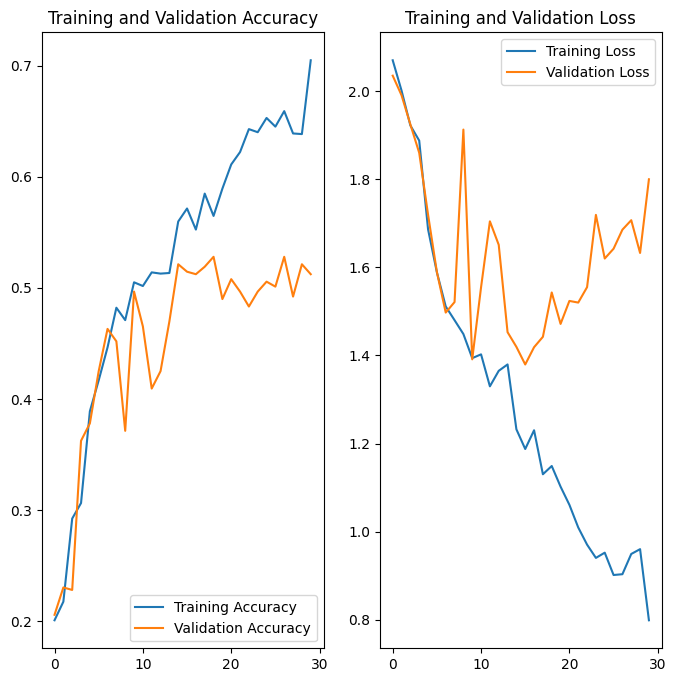

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observation:

The disparity between training accuracy and validation accuracy has notably diminished in comparison to the initial model. This trend is also evident in the training loss and validation loss. Although there is a slight improvement in overall accuracy, it remains modest. This suggests a significant reduction in model overfitting compared to the initial version, yet the overall accuracy does not exhibit substantial enhancement.

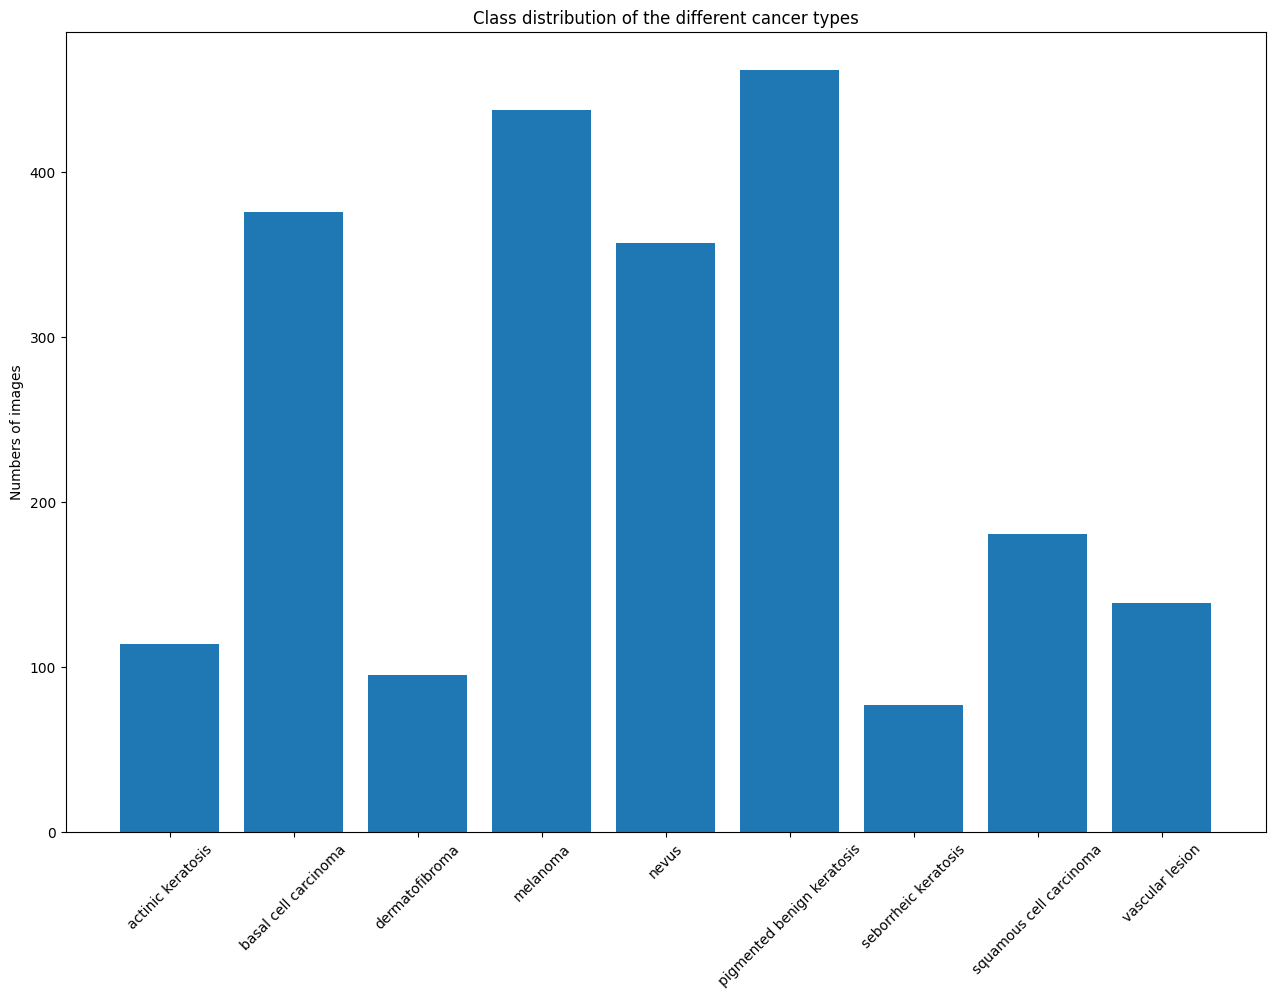

In [34]:
#plot the images to check if all the cancer types are equally distributed
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i in range(len(class_names)):
  x.append(class_names[i])
  y.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

ax.bar(x,y)
ax.set_ylabel('Numbers of images')
ax.set_title('Class distribution of the different cancer types')
plt.xticks(rotation=45)
plt.show()

In [35]:
print("Number of samples for each class: ")
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

Number of samples for each class: 
actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


Observation:

A noticeable class imbalance is evident, revealing that certain classes possess a disproportionately higher number of samples than others. This imbalance can adversely impact the overall quality of the final model. Specifically, the class "seborrheic keratosis" exhibits the lowest sample count, containing only 77 images, while the class "pigmented benign keratosis" boasts the highest count with 462 images. 

To address this class imbalance, the Augmentor library can be employed to artificially generate additional samples, ensuring a more balanced and robust dataset.


In [36]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [37]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train) + '/' + str(i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x378B35F10>: 100%|██████████| 500/500 [00:02<00:00, 191.82 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2940908B0>: 100%|██████████| 500/500 [00:01<00:00, 345.64 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x35EDD3460>: 100%|██████████| 500/500 [00:01<00:00, 339.55 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x35C93FE50>: 100%|██████████| 500/500 [00:07<00:00, 63.43 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x293EE8CD0>: 100%|██████████| 500/500 [00:06<00:00, 77.02 Samples/s]                     


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3766D2C70>: 100%|██████████| 500/500 [00:01<00:00, 328.55 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x35C5B3BE0>: 100%|██████████| 500/500 [00:03<00:00, 153.67 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x29408A820>: 100%|██████████| 500/500 [00:02<00:00, 235.99 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x29407BB50>: 100%|██████████| 500/500 [00:01<00:00, 328.91 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print("Newly generated images with the Augmentor library:", image_count_train)

Newly generated images with the Augmentor library: 4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Train/melanoma/output/melanoma_original_ISIC_0010416.jpg_6d2e307b-aedc-4ee8-b3ec-b1bedcc0faa5.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010131.jpg_7f69dab5-f944-44e6-929c-7201559a22e6.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010993.jpg_fbcbed09-530b-4f2a-a485-0cc9c7526497.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0000450.jpg_00f2e7e7-1877-4a2a-a0db-25bf85ce26cd.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010225.jpg_1261c2a8-0c18-43ca-a1fe-903b1fd39fba.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010527.jpg_5801c07d-8c52-4bc9-ac07-be051763a4b3.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0011174.jpg_9b74ff6c-ad9b-4206-a238-ec8aeb3439b5.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010148.jpg_a2c6201f-2a26-40fe-be18-438664250923.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0000463.jpg_a875c3a2-ac6e-41ae-bfa6-a5fdb233f09f.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0009913.jpg_ddbf28f5-0f6a-46e8-abb3

In [40]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [41]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [42]:
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [43]:
new_df['Label'].value_counts()

Label
melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [44]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=seed,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=seed,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [51]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [52]:
# CNN Model on the data created using Augmentor
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(32,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

In [53]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 45, 45, 128)      

In [54]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


169/169 [==============================] - 21s 108ms/step - loss: 2.1229 - accuracy: 0.2159 - val_loss: 1.6419 - val_accuracy: 0.4143
Epoch 2/20
169/169 [==============================] - 12s 68ms/step - loss: 1.5553 - accuracy: 0.4145 - val_loss: 1.4853 - val_accuracy: 0.4187
Epoch 3/20
169/169 [==============================] - 10s 58ms/step - loss: 1.4052 - accuracy: 0.4894 - val_loss: 1.3541 - val_accuracy: 0.5100
Epoch 4/20
169/169 [==============================] - 10s 58ms/step - loss: 1.2811 - accuracy: 0.5634 - val_loss: 1.5842 - val_accuracy: 0.4662
Epoch 5/20
169/169 [==============================] - 10s 59ms/step - loss: 1.3581 - accuracy: 0.5946 - val_loss: 2.1780 - val_accuracy: 0.5011
Epoch 6/20
169/169 [==============================] - 10s 59ms/step - loss: 1.6709 - accuracy: 0.5992 - val_loss: 2.9559 - val_accuracy: 0.4180
Epoch 7/20
169/169 [==============================] - 11s 63ms/step - loss: 1.8367 - accuracy: 0.6254 - val_loss: 2.6012 - val_accuracy: 0.5278
Ep

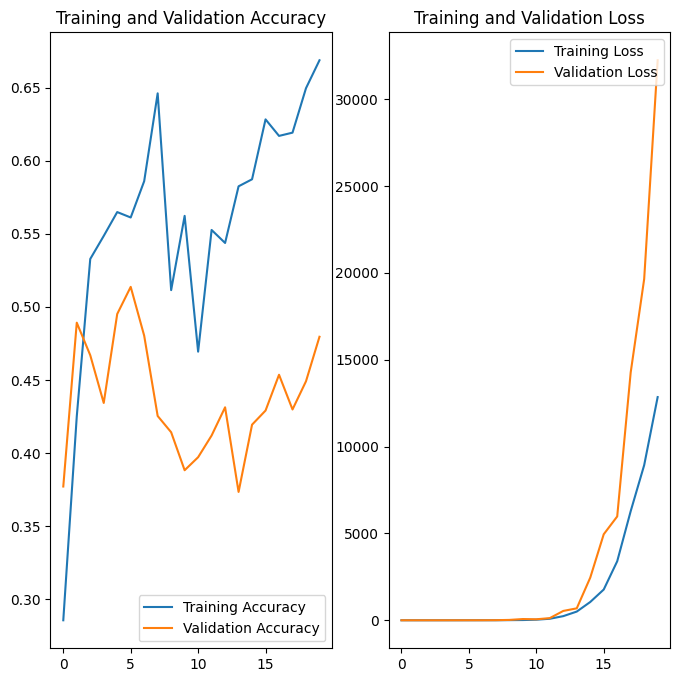

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

With the increase in the training accuracy over time, where as the validation accuracy also increases.
The validation loss also decreases over time.
The gap between training accuracy and validation accuracy has decreased somemore compared to the previous model.